# Contributing Factors Analysis

## README

### Overview
This notebook analyses various spatial datasets that may contribute to or correlate with nitrogen dioxide (NO₂) pollution levels in Ethiopia (Addis Ababa) and Iraq (Baghdad). It focuses on road infrastructure, points of interest (POIs), and population distribution as potential explanatory variables.

### Objective
The goal is to examine the spatial distribution of key human and infrastructural factors that may influence or correlate with nitrogen dioxide (NO₂) pollution levels in urban areas.

### Workflow

1. **Data Acquisition**
   - Downloads datasets from multiple sources:
     - OpenStreetMap (OSM) for roads, industrial facilities, and POIs for [Ethiopia](https://download.geofabrik.de/africa/ethiopia-latest-free.shp.zip) and [Iraq](https://download.geofabrik.de/asia/iraq-latest-free.shp.zip)
     - [WorldPop](https://data.humdata.org/search?q=Spatial+Distribution+of+Population+&ext_search_source=main-nav) for population density
     - [NASA Black Marble](https://blackmarble.gsfc.nasa.gov) for night time light
     - [Google Earth Engine](https://earthengine.google.com) for cloud cover and surface temperature 
   - Imports country and city boundary shapefiles for Ethiopia and Iraq.

2. **Data Processing**
   - Clips all spatial layers to city-level boundaries. 
   - Aggregates various indicators into uniform mesh grids for spatial comparison.

3. **Visualisation**
   - Generates static maps of population density and road infrastructure distribution.
   - Visualises spatial variation in contributing factors to support exploratory analysis.

### Outputs

- **Processed Shapefiles**: City-level road, POI, and infrastructure layers.
- **Mesh-Based Aggregated Tables**: Feature counts and densities per grid cell.
- **Static Visualisations**: Choropleth maps for all contributing factors to aid spatial interpretation.
- **Harmonised Datasets**: All outputs aligned spatially and ready for merging with NO₂ concentration data.

## Init: Prepare Packages and Configuration

Get current file/repo/data path in local to make sure the following cells run properly.

In [1]:
# -----------------------------------------------------------------------------
# STANDARD PATH INITIALISATION (borrowed from Notebook 1)
# -----------------------------------------------------------------------------
%pip install rasterstats
from pathlib import Path
import sys
import geopandas as gpd

CURR_PATH = Path().resolve()            # current file path
REPO_PATH = CURR_PATH.parent            # current repository path
DATA_PATH = REPO_PATH / "data"          # path for saving the data
DEMO_PATH = DATA_PATH / "demo-data"     # path for demo purpose 

SRC_PATH = REPO_PATH / "src"    # path for other sources
sys.path.append(str(SRC_PATH))  # add src to system path to import custom functions

# -----------------------------------------------------------------------------
# IMPORT OSM‐ENRICHMENT AND VISUALISATION HELPERS
# -----------------------------------------------------------------------------
from osmstats import batch_write
#from visualization import plot_mesh_static
from visualization import plot_mesh

# Import customised scripts
from aggregation import*
from missingvalue import*
from visualization import*
from osmstats import*
from helpercollections import*

Note: you may need to restart the kernel to use updated packages.


## 0 Methodology Data Process Pipeline

This chapter processes the contributing factors through the following steps:

- **(1) Filling Missing Value**: Spot the missing values in raster and replenish them using iterative checking, using **mean** of the neighbour raster as the replenish value.

- **(2) Clipping to Region**: Clipping the data to the interested area, and output the filled raster.

- **(3) Aggregation**: Import the generated mesh and aggregate the raster to the mesh level.

## 1 OSM Data

This chapter is used to enrich spatial mesh grids with OpenStreetMap (OSM) data and visualise selected indicators such as POI density, road length, and land-use area.

Note:

* A predefined set of eight POI types (e.g., supermarket, hospital) and six land-use classes (e.g., industrial, residential) are used to filter relevant OSM content.

* OSM enrichment is performed at the mesh level using a batch processing pipeline, resulting in hundreds of `.gpkg` files for each day.

* Static maps are generated to visualise aggregated metrics such as POI share, road length, and industrial land area in square metres.

* These outputs provide spatial insight into the built environment and urban function of regions like Addis Ababa.


#### Ethiopia - Addis Ababa

Define static OSM parameters

In [2]:
# Eight relevant POIs
relevant_poi = [
    "supermarket",
    "hospital",
    "car_dealership",
    "car_rental",
    "car_wash",
    "marketplace",
    "mall",
    "university"
]

# Land‐use categories of interest
landuse_classes = [
    "industrial",
    "commercial",
    "residential",
    "retail",
    "farmland",
    "farmyard"
]

Paths for Addis Ababa

In [3]:
addis_mesh_in  = DATA_PATH / "addis-empty-mesh-data"
addis_mesh_out = DATA_PATH / "addis-OSM-mesh-data"
addis_osm      = DATA_PATH / "OSM" / "ethiopia-latest-free.shp"
ethiopia_pp_path = DATA_PATH / "Power Plants" / "ethiopia_power_fossil.gpkg"

Enrich Addis Ababa — writes ~730 files to addis-OSM-mesh-data

In [5]:
batch_write(
    city="addis",
    mesh_folder_in=addis_mesh_in,
    mesh_folder_out=addis_mesh_out,
    osm_shapefile=addis_osm,
    relevant_poi=relevant_poi,
    landuse_classes=landuse_classes,
    fossil_pp_path=ethiopia_pp_path
)

[addis]  ✓ Saved demo mesh: addis-2023-01-01.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-01.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-02.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-03.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-04.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-05.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-06.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-07.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-08.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-09.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-10.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-11.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-12.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-13.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-14.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-01-15.gpkg
[addis]  ✓ Wrote enriched mesh: addis-ababa-2023-0

Cell “Plot the 2023-01-01 Demo Mesh for QA”

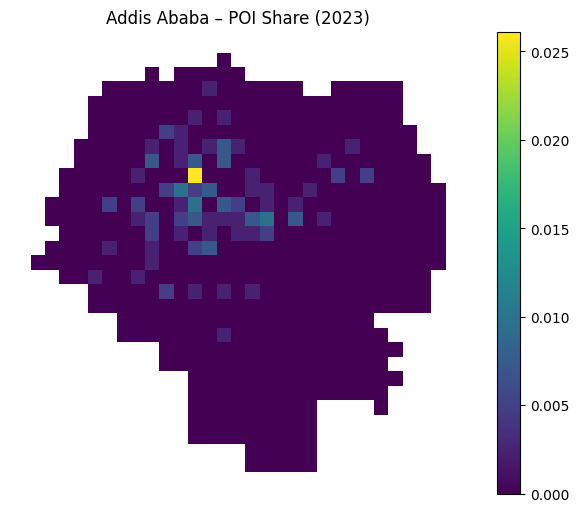

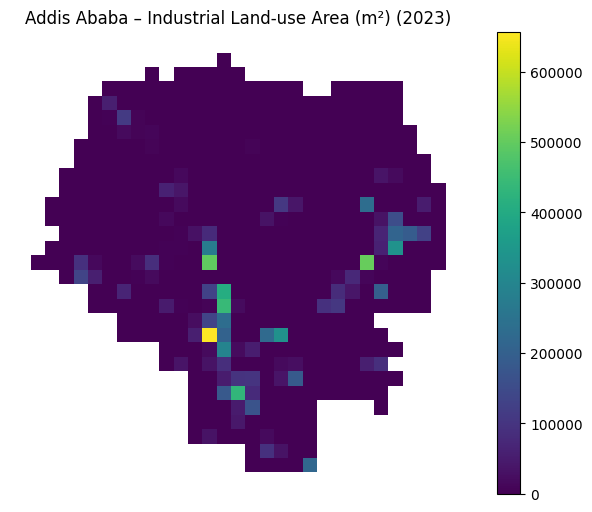

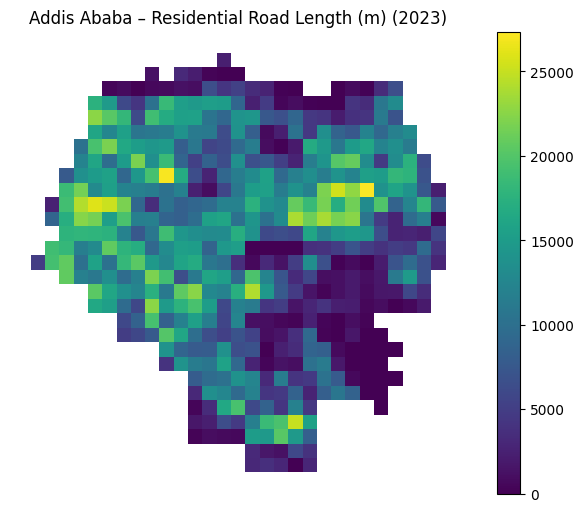

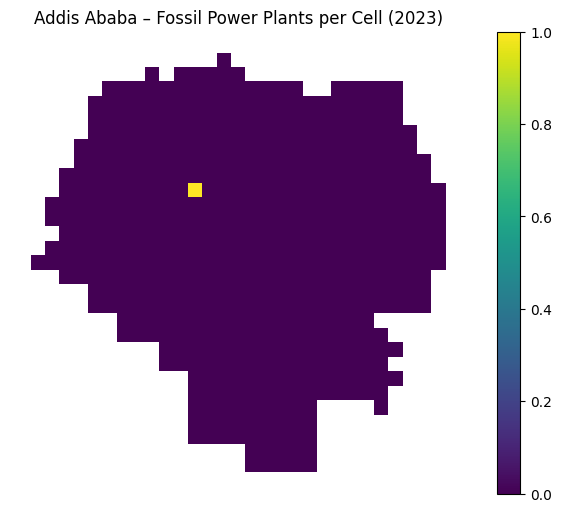

<Axes: title={'center': 'Addis Ababa – Fossil Power Plants per Cell (2023)'}>

In [9]:
demo_dir = DATA_PATH / "demo-data"
#  → “addis-2023-01-01.gpkg” and “baghdad-2023-01-01.gpkg” now exist

# ─── Load the single Addis mesh for QA ────────────────────────────────────────
gdf_addis = gpd.read_file(demo_dir / "addis-ababa-2023-01-01.gpkg")

# POI Share
plot_mesh(
    mesh    = gdf_addis,
    feature = "poi_share",
    title   = "Addis Ababa – POI Share (2023)",
    figsize = (8, 6),
    show    = True,
    cmap    = "viridis",
    show_edges=False
)

# Industrial Land‐use Area
plot_mesh(
    mesh    = gdf_addis,
    feature = "lu_industrial_area",
    title   = "Addis Ababa – Industrial Land‐use Area (m²) (2023)",
    figsize = (8, 6),
    show    = True,
    cmap    = "viridis",
    show_edges=False
)

# ─── NEW: Residential Road Length ───────────────────────────────────────────
plot_mesh(
    mesh    = gdf_addis,
    feature = "road_residential_len",
    title   = "Addis Ababa – Residential Road Length (m) (2023)",
    figsize = (8, 6),
    show    = True,
    cmap    = "viridis",
    show_edges=False
)

# ─── NEW: # of Fossil Power Plants per Cell ─────────────────────────────────
plot_mesh(
    mesh    = gdf_addis,
    feature = "fossil_pp_count",
    title   = "Addis Ababa – Fossil Power Plants per Cell (2023)",
    figsize = (8, 6),
    show    = True,
    cmap    = "viridis",
    show_edges=False
)

#### Iraq - Baghdad

Paths for Baghdad

In [10]:
# -----------------------------------------------------------------------------
# PATHS FOR BAGHDAD
# -----------------------------------------------------------------------------
baghdad_mesh_in  = DATA_PATH / "baghdad-empty-mesh-data"
baghdad_mesh_out = DATA_PATH / "baghdad-OSM-mesh-data"
baghdad_osm      = DATA_PATH / "OSM" / "iraq-latest-free.shp"
iraq_pp_path     = DATA_PATH / "Power Plants" / "iraq_power_fossil.gpkg"

Enrich Baghdad — writes ~730 files to baghdad-OSM-mesh-data

In [11]:
batch_write(
    city="baghdad",
    mesh_folder_in=baghdad_mesh_in,
    mesh_folder_out=baghdad_mesh_out,
    osm_shapefile=baghdad_osm,
    relevant_poi=relevant_poi,
    landuse_classes=landuse_classes,
    fossil_pp_path=iraq_pp_path
)

[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-01.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-02.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-03.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-04.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-05.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-06.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-07.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-08.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-09.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-10.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-11.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-12.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-13.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-14.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-15.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-16.gpkg
[baghdad]  ✓ Wrote enriched mesh: baghdad-2023-01-17.gpkg
[baghdad]  ✓ W

Plot demo mesh for 2023 (already written in `data/demo-data`)

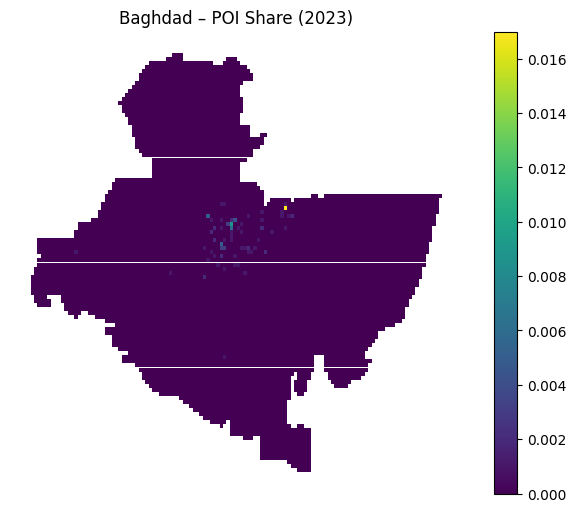

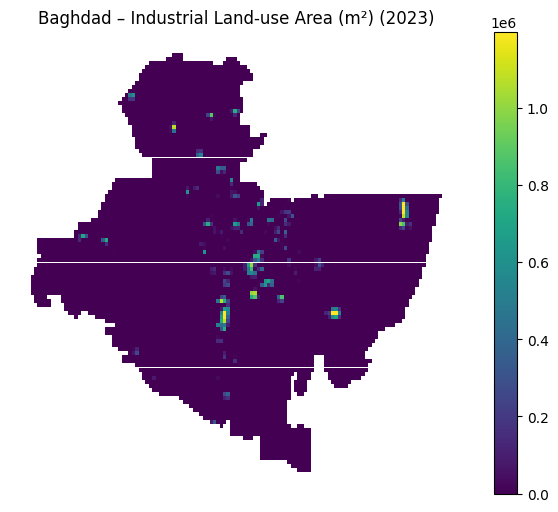

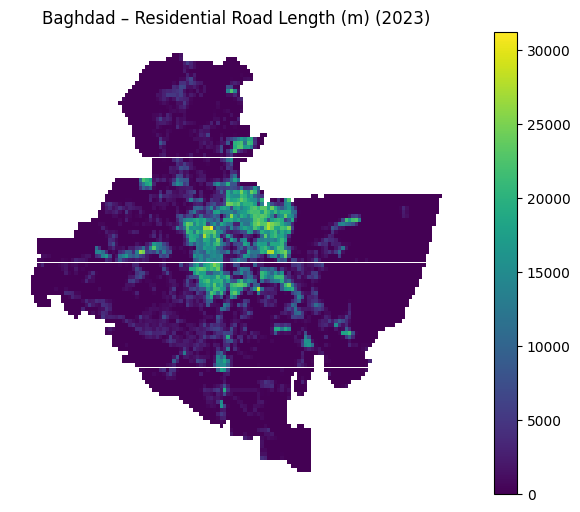

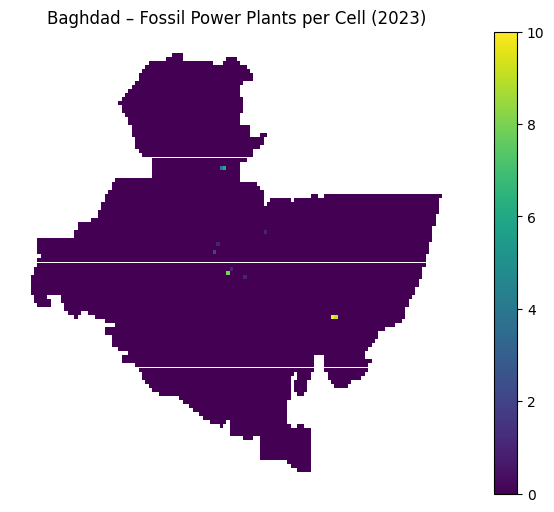

<Axes: title={'center': 'Baghdad – Fossil Power Plants per Cell (2023)'}>

In [12]:
# ─── Load the single Baghdad mesh ────────────────────────────────────────────
gdf_bag = gpd.read_file(demo_dir / "baghdad-2023-01-01.gpkg")

# POI Share
plot_mesh(
    mesh    = gdf_bag,
    feature = "poi_share",
    title   = "Baghdad – POI Share (2023)",
    figsize = (8, 6),
    show    = True, 
    cmap    = "viridis",
    show_edges=False
)

# Industrial Land‐use Area
plot_mesh(
    mesh    = gdf_bag,
    feature = "lu_industrial_area",
    title   = "Baghdad – Industrial Land‐use Area (m²) (2023)",
    figsize = (8, 6),
    show    = True, 
    cmap    = "viridis",
    show_edges=False
)

# ─── NEW: Residential Road Length ───────────────────────────────────────────
plot_mesh(
    mesh    = gdf_bag,
    feature = "road_residential_len",
    title   = "Baghdad – Residential Road Length (m) (2023)",
    figsize = (8, 6),
    show    = True,
    cmap    = "viridis",
    show_edges=False
)

# ─── NEW: # of Fossil Power Plants per Cell ─────────────────────────────────
plot_mesh(
    mesh    = gdf_bag,
    feature = "fossil_pp_count",
    title   = "Baghdad – Fossil Power Plants per Cell (2023)",
    figsize = (8, 6),
    show    = True,
    cmap    = "viridis",
    show_edges=False
)


## 2 Population Data

This chapter is used to aggregate and visualise population distribution in different regions using mesh grids.

Note:

* The population data is aggregated based on predefined hexagonal or square mesh grids using zonal statistics.

* Yearly aggregated population values are stored as `.gpkg` files, with one file for each day to support temporal analysis.

* Static maps are generated to visualise the spatial distribution of population across the mesh in each year.

* The workflow supports comparison across multiple years (e.g., 2023 and 2024), enabling temporal change analysis.

In [3]:
# ------------------------------------------------------------------------------
# INITIALISE MESH PATHS AND READ GPKG LAYERS
# ------------------------------------------------------------------------------

addis_meshes_path = DATA_PATH / 'addis-mesh-data'       # path to folder storing Addis mesh files
baghdad_meshes_path = DATA_PATH / 'baghdad-mesh-data'   # path to folder storing Baghdad mesh files

mesh_addis = DATA_PATH / "mesh-grid" / "grid_addis_ababa.gpkg"     # full path to Addis Ababa mesh grid file
mesh_baghdad = DATA_PATH / "mesh-grid" / "grid_baghdad.gpkg"       # full path to Baghdad mesh grid file

lyr_addis_name = fiona.listlayers(mesh_addis)[0]        # extract the only layer name in the Addis GPKG
lyr_baghdad_name = fiona.listlayers(mesh_baghdad)[0]    # extract the only layer name in the Baghdad GPKG

#### Ethiopia - Addis Ababa

In [4]:
output_root = DATA_PATH / "eth-pop-gpkg"          # path for saving the data
eth_pop_path = DATA_PATH / 'eth-pop'

aggregate_pop_data(
    data_tiff_path=eth_pop_path,
    mesh_path=mesh_addis,
    layer_name=lyr_addis_name,
    agg_type="sum",
    feature_col="pop_sum_m",
    output_path=output_root
)

Currently working on: 1/2, Year: 2023
Saved: C:\Users\26454\OneDrive - Imperial College London\Documents\GitHub\air-pollution-mobility-research-project\data\eth-pop-gpkg\pop_aggregated_2023.gpkg
Currently working on: 2/2, Year: 2024
Saved: C:\Users\26454\OneDrive - Imperial College London\Documents\GitHub\air-pollution-mobility-research-project\data\eth-pop-gpkg\pop_aggregated_2024.gpkg


In [ ]:
# Filter for .gpkg files that contain "2023" in the filename
gpkg_files_2023_eth = [f for f in addis_meshes_path.glob("*.gpkg") if "2023" in f.name]
print(f"There are {len(gpkg_files_2023_eth)} files from the year 2023.")

# Filter for .gpkg files that contain "2023" in the filename
gpkg_files_2024_eth = [f for f in addis_meshes_path.glob("*.gpkg") if "2024" in f.name]
print(f"There are {len(gpkg_files_2024_eth)} files from the year 2024.")

There are 365 files from the year 2023.
There are 366 files from the year 2024.


In [ ]:
# Input file paths
src_2023_eth = DATA_PATH / "eth-pop-gpkg" / "pop_aggregated_2023.gpkg"
src_2024_eth = DATA_PATH / "eth-pop-gpkg" / "pop_aggregated_2024.gpkg"

# Output directory 
output_path = DATA_PATH

# Run for 2023 and 2024
generate_daily_files(src_2023_eth, 2023, 365, "addis-ababa", output_path)
generate_daily_files(src_2024_eth, 2024, 366, "addis-ababa", output_path)

Done: 365 files created for 2023.
Done: 366 files created for 2024.


**Visualisation**

Show aggregated result in 2023 and 2024 for Addis Ababa.

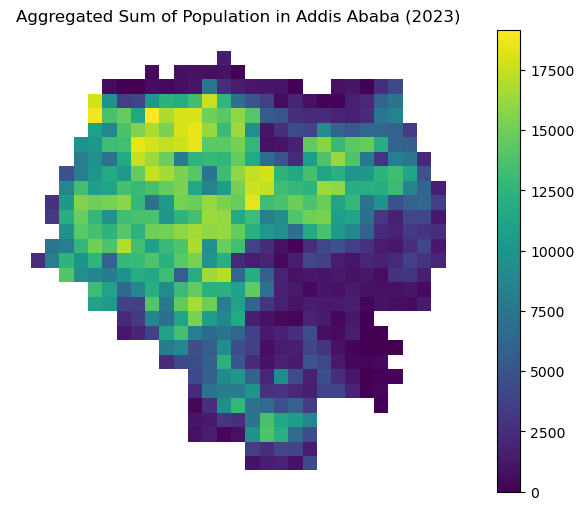

In [7]:
pop_2023_eth = gpd.read_file(DATA_PATH / "pop-files-addis-ababa" / "addis-ababa-2023-02-21.gpkg")
plot_mesh(mesh=pop_2023_eth, feature="pop_sum_m", title="Aggregated Sum of Population in Addis Ababa (2023)", show_edges=False)
plt.show()

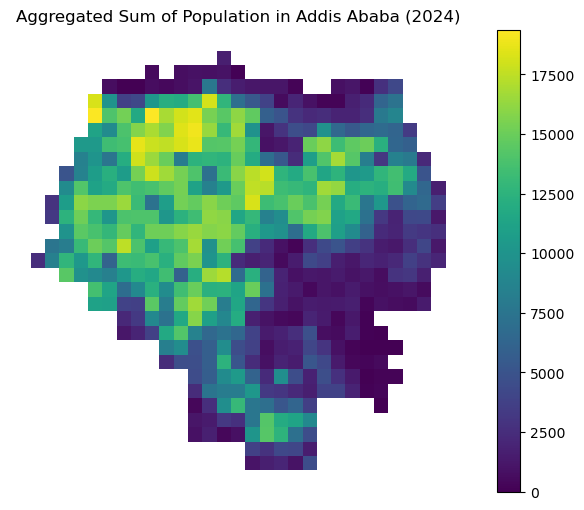

In [8]:
pop_2024_eth = gpd.read_file(DATA_PATH / "pop-files-addis-ababa" / "addis-ababa-2024-02-21.gpkg")
plot_mesh(mesh=pop_2024_eth, feature="pop_sum_m", title="Aggregated Sum of Population in Addis Ababa (2024)", show_edges=False)
plt.show()

#### Iraq - Baghdad

In [9]:
output_root = DATA_PATH / "iraq-pop-gpkg"          # path for saving the data
iraq_pop_path = DATA_PATH / 'iraq-pop'

aggregate_pop_data(
    data_tiff_path=iraq_pop_path,
    mesh_path=mesh_baghdad,
    layer_name=lyr_baghdad_name,
    agg_type="sum",
    feature_col="pop_sum_m",
    output_path=output_root
)

Currently working on: 1/2, Year: 2023
Saved: C:\Users\26454\OneDrive - Imperial College London\Documents\GitHub\air-pollution-mobility-research-project\data\iraq-pop-gpkg\pop_aggregated_2023.gpkg
Currently working on: 2/2, Year: 2024
Saved: C:\Users\26454\OneDrive - Imperial College London\Documents\GitHub\air-pollution-mobility-research-project\data\iraq-pop-gpkg\pop_aggregated_2024.gpkg


In [10]:
# Filter for .gpkg files that contain "2023" in the filename
gpkg_files_2023_iraq = [f for f in baghdad_meshes_path.glob("*.gpkg") if "2023" in f.name]
print(f"There are {len(gpkg_files_2023_iraq)} files from the year 2023.")

# Filter for .gpkg files that contain "2023" in the filename
gpkg_files_2024_iraq = [f for f in baghdad_meshes_path.glob("*.gpkg") if "2024" in f.name]
print(f"There are {len(gpkg_files_2024_iraq)} files from the year 2024.")

There are 365 files from the year 2023.
There are 366 files from the year 2024.


In [11]:
# Input file paths
src_2023_iraq = DATA_PATH / "iraq-pop-gpkg" / "pop_aggregated_2023.gpkg"
src_2024_iraq = DATA_PATH / "iraq-pop-gpkg" / "pop_aggregated_2024.gpkg"

# Output directory 
output_path = DATA_PATH 

# Run for 2023 and 2024
generate_daily_files(src_2023_iraq, 2023, 365, "baghdad", output_path)
generate_daily_files(src_2024_iraq, 2024, 366, "baghdad", output_path)

Done: 365 files created for 2023.
Done: 366 files created for 2024.


**Visualisation**

Show aggregated result in 2023 and 2024 for Baghdad.

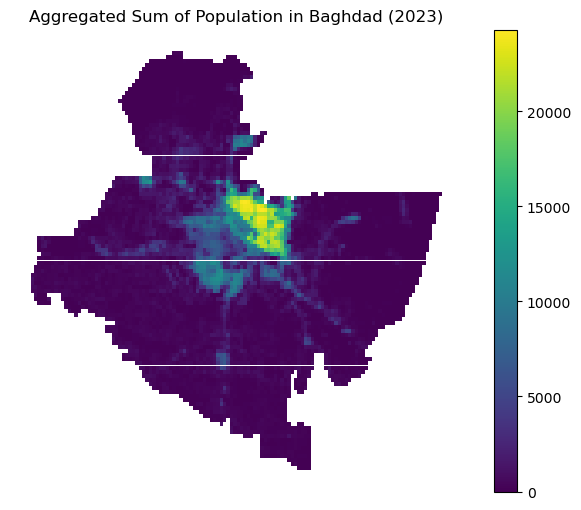

In [12]:
pop_2023_iraq = gpd.read_file(DATA_PATH / "pop-files-baghdad" / "baghdad-2023-02-21.gpkg")
plot_mesh(mesh=pop_2023_iraq, feature="pop_sum_m", title="Aggregated Sum of Population in Baghdad (2023)", show_edges=False)
plt.show()

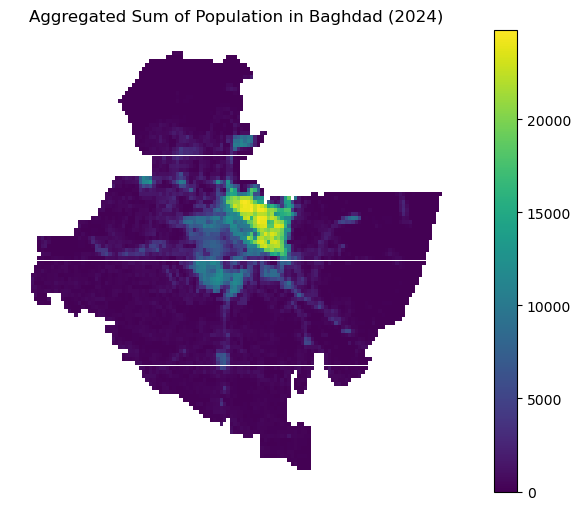

In [13]:
pop_2024_iraq = gpd.read_file(DATA_PATH / "pop-files-baghdad" / "baghdad-2024-02-21.gpkg")
plot_mesh(mesh=pop_2024_iraq, feature="pop_sum_m", title="Aggregated Sum of Population in Baghdad (2024)", show_edges=False)
plt.show()

## 3 Night Time Light

In [13]:
import rasterio
from aggregation import*

output_path = DATA_PATH
addis_meshes_path = DATA_PATH / 'addis-mesh-data'
baghdad_meshes_path = DATA_PATH / 'baghdad-mesh-data'

mesh_addis = DATA_PATH / "mesh-grid" / "grid_addis_ababa.gpkg"
mesh_baghdad = DATA_PATH / "mesh-grid" / "grid_baghdad.gpkg"

lyr_addis_name = fiona.listlayers(mesh_addis)[0]         # control layer number = 1 
lyr_baghdad_name = fiona.listlayers(mesh_baghdad)[0]

#### Ethiopia - Addis Ababa

Clip the raster to interested area.

In [ ]:
min_lon, max_lon = 38.65, 39.05
min_lat, max_lat = 8.8, 9.1

addis_ntl_tiff = DATA_PATH / "addis-ababa-NTL-tiffs"
clip_tiff_by_bbox('addis-ababa', addis_ntl_tiff, output_path,
                      min_lon, min_lat, max_lon, max_lat,)

Fill the missing data in the raster.

In [ ]:
addis_ntl_clipped = DATA_PATH / "addis-ababa-NTL-clipped"

fill_ntl_missing_data(
    city = 'addis-ababa',
    data_tiff_path = addis_ntl_clipped,
    output_path = DATA_PATH,
)

Generate TIFF Animation

Scanning percentiles: 100%|██████████| 731/731 [00:06<00:00, 110.52it/s]


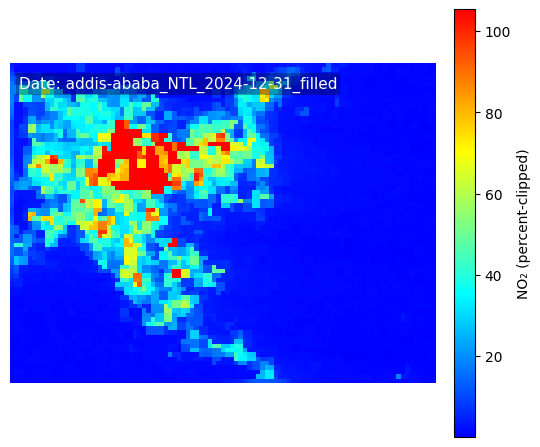

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\addis-ababa-NTL-animation.gif


In [11]:
addis_ntl_tif_dir = DATA_PATH / 'addis-ababa-NTL-filled'  
tiff_2_gif(addis_ntl_tif_dir, output_path=DATA_PATH, output_name="addis-ababa-NTL-animation", fps = 8)

Aggregate to Mesh

In [ ]:
# Aggregate Ethiopia - Addis Ababa
addis_ntl_tif_dir = DATA_PATH / 'baghdad-NTL-filled'  
aggregate_data(
    data_tiff_path=addis_ntl_tif_dir, 
    mesh_path=baghdad_meshes_path, 
    layer_name=lyr_baghdad_name,
    feature_name="NTL_mean"
    )

#### Iraq - Baghdad

Clip the raster to interested area.

In [ ]:
min_lon, max_lon = 43.7, 45.0
min_lat, max_lat = 32.7, 33.8

baghdad_ntl_tiff = DATA_PATH / "baghdad-NTL-tiffs"
clip_tiff_by_bbox('baghdad', baghdad_ntl_tiff, output_path,
                      min_lon, min_lat, max_lon, max_lat,)

Fill the missing data in the raster.

In [ ]:
baghdad_ntl_clipped = DATA_PATH / "baghdad-NTL-clipped"

fill_ntl_missing_data(
    city = 'baghdad',
    data_tiff_path = baghdad_ntl_clipped,
    output_path = DATA_PATH,
)

Generate TIFF Animation

Scanning percentiles: 100%|██████████| 701/701 [00:07<00:00, 88.71it/s]


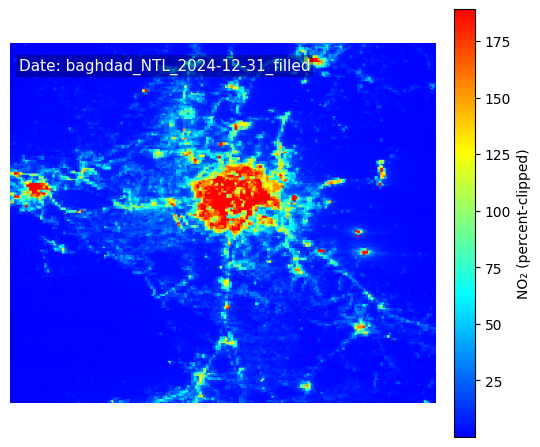

Animation saved to: D:\Projects\MSc_Group_Project\air-pollution-mobility-research-project\data\animation-output\baghdad-NTL-animation.gif


In [ ]:
baghdad_ntl_tif_dir = DATA_PATH / 'baghdad-NTL-filled'  
tiff_2_gif(baghdad_ntl_tif_dir, output_path=DATA_PATH, output_name="baghdad-NTL-animation", fps = 8)

Aggregate to Mesh

In [ ]:
# Aggregate Ethiopia - Addis Ababa
baghdad_ntl_tif_dir = DATA_PATH / 'baghdad-NTL-filled'  
aggregate_data(
    data_tiff_path=baghdad_ntl_tif_dir, 
    mesh_path=baghdad_meshes_path, 
    layer_name=lyr_baghdad_name,
    feature_name="NTL_mean"
    )

## 4 Cloud cover

### Ethiopia

In [2]:
output_path = DATA_PATH
addis_meshes_path = DATA_PATH / 'addis-mesh-data'
baghdad_meshes_path = DATA_PATH / 'baghdad-mesh-data'

mesh_addis = DATA_PATH / "mesh-grid" / "grid_addis_ababa.gpkg"
mesh_baghdad = DATA_PATH / "mesh-grid" / "grid_baghdad.gpkg"

lyr_addis_name = fiona.listlayers(mesh_addis)[0]         # control layer number = 1 
lyr_baghdad_name = fiona.listlayers(mesh_baghdad)[0]


In [3]:
min_lon, max_lon = 38.65, 39.05
min_lat, max_lat = 8.8, 9.1

In [8]:
addis_cloud_tiff = data_folder = "../data/Cloud_AddisAbaba" 
clip_cloud_tiff_by_bbox('addis-ababa', addis_cloud_tiff, output_path,
                      min_lon, min_lat, max_lon, max_lat,)

Processing 1/730: CloudState_Addis-Ababa_20230101.tif
Processing 2/730: CloudState_Addis-Ababa_20230102.tif
Processing 3/730: CloudState_Addis-Ababa_20230103.tif
Processing 4/730: CloudState_Addis-Ababa_20230104.tif
Processing 5/730: CloudState_Addis-Ababa_20230105.tif
Processing 6/730: CloudState_Addis-Ababa_20230106.tif
Processing 7/730: CloudState_Addis-Ababa_20230107.tif
Processing 8/730: CloudState_Addis-Ababa_20230108.tif
Processing 9/730: CloudState_Addis-Ababa_20230109.tif
Processing 10/730: CloudState_Addis-Ababa_20230110.tif
Processing 11/730: CloudState_Addis-Ababa_20230111.tif
Processing 12/730: CloudState_Addis-Ababa_20230112.tif
Processing 13/730: CloudState_Addis-Ababa_20230113.tif
Processing 14/730: CloudState_Addis-Ababa_20230114.tif
Processing 15/730: CloudState_Addis-Ababa_20230115.tif
Processing 16/730: CloudState_Addis-Ababa_20230116.tif
Processing 17/730: CloudState_Addis-Ababa_20230117.tif
Processing 18/730: CloudState_Addis-Ababa_20230118.tif
Processing 19/730: 

PosixPath('/Users/ll/Documents/GitHub/air-pollution-mobility-research-project/data/addis-ababa-cloud-clipped')

In [4]:
addis_cloud_clipped = DATA_PATH / "addis-ababa-cloud-clipped"

fill_cloud_missing_data(
    city = 'addis-ababa',
    data_tiff_path = addis_cloud_clipped,
    output_path = DATA_PATH,
)

Processing 1/730: 2023-01-01
Processing 2/730: 2023-01-02
Processing 3/730: 2023-01-03
Processing 4/730: 2023-01-04
Processing 5/730: 2023-01-05
Processing 6/730: 2023-01-06
Processing 7/730: 2023-01-07
Processing 8/730: 2023-01-08


/Users/ll/Documents/GitHub/air-pollution-mobility-research-project/src/missingvalue.py:60: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr) if np.isnan(center) else center


Processing 9/730: 2023-01-09
Processing 10/730: 2023-01-10
Processing 11/730: 2023-01-11
Processing 12/730: 2023-01-12
Processing 13/730: 2023-01-13
Processing 14/730: 2023-01-14
Processing 15/730: 2023-01-15
Processing 16/730: 2023-01-16
Processing 17/730: 2023-01-17
Processing 18/730: 2023-01-18
Processing 19/730: 2023-01-19
Processing 20/730: 2023-01-20
Processing 21/730: 2023-01-21
Processing 22/730: 2023-01-22
Processing 23/730: 2023-01-23
Processing 24/730: 2023-01-24
Processing 25/730: 2023-01-25
Processing 26/730: 2023-01-26
Processing 27/730: 2023-01-27
Processing 28/730: 2023-01-28
Processing 29/730: 2023-01-29
Processing 30/730: 2023-01-30
Processing 31/730: 2023-01-31
Processing 32/730: 2023-02-01
Processing 33/730: 2023-02-02
Processing 34/730: 2023-02-03
Processing 35/730: 2023-02-04
Processing 36/730: 2023-02-05
Processing 37/730: 2023-02-06
Processing 38/730: 2023-02-07
Processing 39/730: 2023-02-08
Processing 40/730: 2023-02-09
Processing 41/730: 2023-02-10
Processing 

**Visualisation**

The data before and after data filling is illustrated below:

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# plot original image
src, band, profile, nodata_value = read_tiff(DEMO_PATH / 'baghdad-cloud-clipped/ CloudState_Baghdad_2023_01_01.tif')
plot_raster(band, percent_clip=0.5, ax=axes[0], title="Original Satellite Image")

# filled image
src, band_filled, profile, nodata_value = read_tiff(DEMO_PATH / 'baghdad-cloud-filled/ baghdad_Cloud_2023-01-01_filled.tif')
plot_raster(band_filled, percent_clip=0.5, ax=axes[1], title="Filled Values Satellite Image")

plt.show()

Animation

In [5]:
addis_cloud_tif_dir = DATA_PATH / 'addis-ababa-cloud-filled'  
tiff_2_gif_cloud(addis_cloud_tif_dir, output_path=DATA_PATH, output_name="addis-ababa-cloud-animation", fps = 8)

GIF saved to: /Users/ll/Documents/GitHub/air-pollution-mobility-research-project/data/animation-output/addis-ababa-cloud-animation.gif


In [3]:
addis_cloud_tif_dir = DATA_PATH / 'addis-ababa-cloud-filled'  

aggregate_cloud_data(
    data_tiff_path=addis_cloud_tif_dir, 
    mesh_path=addis_meshes_path, 
    layer_name=lyr_addis_name,
    feature_name="cloud_category"
)


[1/730] Aggregating cloud state: 2023-01-01
cloud_category
1.000000          266
0.000000          254
2.000000           25
0.608696            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-01.gpkg
[2/730] Aggregating cloud state: 2023-01-02
cloud_category
1.000000          524
0.000000           21
0.869565            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-02.gpkg
[3/730] Aggregating cloud state: 2023-01-03
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-03.gpkg
[4/730] Aggregating cloud state: 2023-01-04
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-04.gpkg
[5/730] Aggregating cloud state: 2023-01-05
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-05.gpkg
[6/730] Aggregating cloud state: 20

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-01-10.gpkg': 'addis-ababa-2023-01-10' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-10.gpkg
[11/730] Aggregating cloud state: 2023-01-11
cloud_category
0.0               528
1.0                18
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-11.gpkg
[12/730] Aggregating cloud state: 2023-01-12
cloud_category
0.0               486
1.0                60
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-12.gpkg
[13/730] Aggregating cloud state: 2023-01-13
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-13.gpkg
[14/730] Aggregating cloud state: 2023-01-14
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-14.gpkg
[15/730] Aggregating cloud state: 2023-01-15
cloud_category
0.000000          394
1.000000          151
0.369565            1
Name: count, dt

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-01-27.gpkg': 'addis-ababa-2023-01-27' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               515
1.0                31
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-27.gpkg
[28/730] Aggregating cloud state: 2023-01-28
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-28.gpkg
[29/730] Aggregating cloud state: 2023-01-29
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-29.gpkg
[30/730] Aggregating cloud state: 2023-01-30
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-30.gpkg
[31/730] Aggregating cloud state: 2023-01-31
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-01-31.gpkg
[32/730] Aggregating cloud state: 2023-02-01
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-02-04.gpkg': 'addis-ababa-2023-02-04' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-04.gpkg
[36/730] Aggregating cloud state: 2023-02-05
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-05.gpkg
[37/730] Aggregating cloud state: 2023-02-06
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-06.gpkg
[38/730] Aggregating cloud state: 2023-02-07
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-07.gpkg
[39/730] Aggregating cloud state: 2023-02-08
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-08.gpkg
[40/730] Aggregating cloud state: 2023-02-09


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-02-09.gpkg': 'addis-ababa-2023-02-09' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-09.gpkg
[41/730] Aggregating cloud state: 2023-02-10
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-10.gpkg
[42/730] Aggregating cloud state: 2023-02-11
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-11.gpkg
[43/730] Aggregating cloud state: 2023-02-12
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-12.gpkg
[44/730] Aggregating cloud state: 2023-02-13
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-13.gpkg
[45/730] Aggregating cloud state: 2023-02-14
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-14.gpkg
[46/730] Aggr

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-02-15.gpkg': 'addis-ababa-2023-02-15' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-15.gpkg
[47/730] Aggregating cloud state: 2023-02-16
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-16.gpkg
[48/730] Aggregating cloud state: 2023-02-17
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-17.gpkg
[49/730] Aggregating cloud state: 2023-02-18
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-18.gpkg
[50/730] Aggregating cloud state: 2023-02-19
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-19.gpkg
[51/730] Aggregating cloud state: 2023-02-20
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-20.gpkg
[52/730] Aggr

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-02-22.gpkg': 'addis-ababa-2023-02-22' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-22.gpkg
[54/730] Aggregating cloud state: 2023-02-23
cloud_category
0.0               501
1.0                45
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-23.gpkg
[55/730] Aggregating cloud state: 2023-02-24
cloud_category
0.0               479
1.0                67
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-24.gpkg
[56/730] Aggregating cloud state: 2023-02-25
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-25.gpkg
[57/730] Aggregating cloud state: 2023-02-26
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-02-26.gpkg
[58/730] Aggregating cloud state: 2023-02-27
cloud_category
0.000000          381
1.000000          164
0.413043            1
Name: count, dt

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-03-07.gpkg': 'addis-ababa-2023-03-07' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-07.gpkg
[67/730] Aggregating cloud state: 2023-03-08
cloud_category
0.0               503
1.0                43
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-08.gpkg
[68/730] Aggregating cloud state: 2023-03-09
cloud_category
1.00000           463
0.00000            82
0.76087             1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-09.gpkg
[69/730] Aggregating cloud state: 2023-03-10
cloud_category
1.000000          304
0.000000          195
2.000000           46
0.847826            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-10.gpkg
[70/730] Aggregating cloud state: 2023-03-11
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-11.gpkg
[71/730] Aggregating cloud state: 2023-03-12
cloud_ca

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-03-16.gpkg': 'addis-ababa-2023-03-16' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          517
0.000000           28
0.956522            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-16.gpkg
[76/730] Aggregating cloud state: 2023-03-17
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-17.gpkg
[77/730] Aggregating cloud state: 2023-03-18
cloud_category
0.0               284
1.0               262
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-18.gpkg
[78/730] Aggregating cloud state: 2023-03-19
cloud_category
1.000000          463
0.000000           78
2.000000            4
0.934783            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-19.gpkg
[79/730] Aggregating cloud state: 2023-03-20
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-20.gpkg
[80/730] Aggregating cloud state: 2023-03-21


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-03-21.gpkg': 'addis-ababa-2023-03-21' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-21.gpkg
[81/730] Aggregating cloud state: 2023-03-22
cloud_category
0.0               447
1.0                99
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-22.gpkg
[82/730] Aggregating cloud state: 2023-03-23
cloud_category
1.000000          465
0.000000           44
2.000000           36
0.847826            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-23.gpkg
[83/730] Aggregating cloud state: 2023-03-24
cloud_category
0.0               306
1.0               240
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-24.gpkg
[84/730] Aggregating cloud state: 2023-03-25
cloud_category
0.000000          349
1.000000          196
0.217391            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-03-25.gpkg
[85/730] Aggregating cloud stat

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-04-13.gpkg': 'addis-ababa-2023-04-13' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-04-13.gpkg
[104/730] Aggregating cloud state: 2023-04-14
cloud_category
0.0               361
1.0               185
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-04-14.gpkg
[105/730] Aggregating cloud state: 2023-04-15
cloud_category
1.000000          443
0.000000          102
0.717391            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-04-15.gpkg
[106/730] Aggregating cloud state: 2023-04-16
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-04-16.gpkg
[107/730] Aggregating cloud state: 2023-04-17
cloud_category
1.000000          363
0.000000          182
0.630435            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-04-17.gpkg
[108/730] Aggregating cloud state: 2023-04-18
cloud_category
NaN       

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-04-24.gpkg': 'addis-ababa-2023-04-24' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          439
0.000000          106
0.673913            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-04-24.gpkg
[115/730] Aggregating cloud state: 2023-04-25
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-04-25.gpkg
[116/730] Aggregating cloud state: 2023-04-26
cloud_category
1.000000          301
0.000000          244
0.521739            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-04-26.gpkg
[117/730] Aggregating cloud state: 2023-04-27
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-04-27.gpkg
[118/730] Aggregating cloud state: 2023-04-28
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-04-28.gpkg
[119/730] Aggregating cloud state: 2023-04-29
cloud_category
1.000000          531
0.000000  

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-05-10.gpkg': 'addis-ababa-2023-05-10' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          536
0.000000            9
0.913043            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-05-10.gpkg
[131/730] Aggregating cloud state: 2023-05-11
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-05-11.gpkg
[132/730] Aggregating cloud state: 2023-05-12
cloud_category
1.000000          522
0.000000           23
0.804348            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-05-12.gpkg
[133/730] Aggregating cloud state: 2023-05-13
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-05-13.gpkg
[134/730] Aggregating cloud state: 2023-05-14
cloud_category
1.00000           521
0.00000            24
0.73913             1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-05-14.gpkg
[135/730] Aggregating cloud state: 2023-05-15
clo

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-05-27.gpkg': 'addis-ababa-2023-05-27' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          434
0.000000          111
0.913043            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-05-27.gpkg
[148/730] Aggregating cloud state: 2023-05-28
cloud_category
0.0               434
1.0               112
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-05-28.gpkg
[149/730] Aggregating cloud state: 2023-05-29
cloud_category
0.0               542
1.0                 4
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-05-29.gpkg
[150/730] Aggregating cloud state: 2023-05-30
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-05-30.gpkg
[151/730] Aggregating cloud state: 2023-05-31
cloud_category
0.0               300
1.0               246
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-05-31.gpkg
[152/730] Aggregating cloud state: 2023-06-01
cloud_category
1.000000  

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-06-09.gpkg': 'addis-ababa-2023-06-09' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-09.gpkg
[161/730] Aggregating cloud state: 2023-06-10
cloud_category
1.000000          498
0.000000           47
0.891304            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-10.gpkg
[162/730] Aggregating cloud state: 2023-06-11
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-11.gpkg
[163/730] Aggregating cloud state: 2023-06-12
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-12.gpkg
[164/730] Aggregating cloud state: 2023-06-13
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-13.gpkg
[165/730] Aggregating cloud state: 2023-06-14
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' wri

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-06-15.gpkg': 'addis-ababa-2023-06-15' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          505
0.000000           40
0.978261            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-15.gpkg
[167/730] Aggregating cloud state: 2023-06-16
cloud_category
1.000000          291
0.000000          229
2.000000           25
0.630435            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-16.gpkg
[168/730] Aggregating cloud state: 2023-06-17
cloud_category
0.0               356
1.0               190
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-17.gpkg
[169/730] Aggregating cloud state: 2023-06-18


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-06-18.gpkg': 'addis-ababa-2023-06-18' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-18.gpkg
[170/730] Aggregating cloud state: 2023-06-19
cloud_category
1.000000          403
0.000000          142
0.695652            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-19.gpkg
[171/730] Aggregating cloud state: 2023-06-20
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-20.gpkg
[172/730] Aggregating cloud state: 2023-06-21
cloud_category
1.000000          502
0.000000           43
0.934783            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-21.gpkg
[173/730] Aggregating cloud state: 2023-06-22


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-06-22.gpkg': 'addis-ababa-2023-06-22' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-22.gpkg
[174/730] Aggregating cloud state: 2023-06-23
cloud_category
0.0               290
1.0               256
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-23.gpkg
[175/730] Aggregating cloud state: 2023-06-24
cloud_category
1.000000          482
0.000000           63
0.630435            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-24.gpkg
[176/730] Aggregating cloud state: 2023-06-25
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-25.gpkg
[177/730] Aggregating cloud state: 2023-06-26
cloud_category
0.0               500
1.0                46
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-06-26.gpkg
[178/730] Aggregating cloud state: 2023-06-27
cloud_category
1.0               546
Name: coun

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-07-16.gpkg': 'addis-ababa-2023-07-16' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-07-16.gpkg
[198/730] Aggregating cloud state: 2023-07-17
cloud_category
0.0               446
1.0               100
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-07-17.gpkg
[199/730] Aggregating cloud state: 2023-07-18
cloud_category
1.000000          535
0.000000           10
0.826087            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-07-18.gpkg
[200/730] Aggregating cloud state: 2023-07-19
cloud_category
0.0               379
1.0               167
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-07-19.gpkg
[201/730] Aggregating cloud state: 2023-07-20
cloud_category
0.0               348
1.0               198
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-07-20.gpkg
[202/730] Aggregating cloud state: 2023-07-21


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-07-21.gpkg': 'addis-ababa-2023-07-21' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-07-21.gpkg
[203/730] Aggregating cloud state: 2023-07-22
cloud_category
0.000000          227
1.000000          153
0.583333           33
0.640000           25
0.600000           24
0.535714           21
0.656250           20
0.705882           15
0.521739           14
0.555556           10
0.461538            3
0.692308            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-07-22.gpkg
[204/730] Aggregating cloud state: 2023-07-23
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-07-23.gpkg
[205/730] Aggregating cloud state: 2023-07-24
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-07-24.gpkg
[206/730] Aggregating cloud state: 2023-07-25
cloud_category
1.000000          451
0.000000           94
0.91304

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-08-12.gpkg': 'addis-ababa-2023-08-12' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               470
1.0                76
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-08-12.gpkg
[225/730] Aggregating cloud state: 2023-08-13
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-08-13.gpkg
[226/730] Aggregating cloud state: 2023-08-14
cloud_category
1.0               429
0.0               117
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-08-14.gpkg
[227/730] Aggregating cloud state: 2023-08-15
cloud_category
0.0               439
1.0               107
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-08-15.gpkg
[228/730] Aggregating cloud state: 2023-08-16
cloud_category
0.0               362
1.0               171
2.0                13
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-08-16.gpkg
[229/730] Aggregating cloud state: 2023-08-17
cloud_category
1.000000  

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-08-25.gpkg': 'addis-ababa-2023-08-25' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-08-25.gpkg
[238/730] Aggregating cloud state: 2023-08-26
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-08-26.gpkg
[239/730] Aggregating cloud state: 2023-08-27
cloud_category
1.000000          437
0.000000          108
0.630435            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-08-27.gpkg
[240/730] Aggregating cloud state: 2023-08-28
cloud_category
0.000000          310
1.000000          235
0.369565            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-08-28.gpkg
[241/730] Aggregating cloud state: 2023-08-29
cloud_category
1.000000          511
0.000000           34
0.978261            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-08-29.gpkg
[242/730] Aggregating cloud state: 2023-08-30
clo

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-09-11.gpkg': 'addis-ababa-2023-09-11' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          475
0.000000           70
0.956522            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-09-11.gpkg
[255/730] Aggregating cloud state: 2023-09-12
cloud_category
1.000000          350
0.000000          195
0.695652            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-09-12.gpkg
[256/730] Aggregating cloud state: 2023-09-13
cloud_category
0.0               361
1.0               165
2.0                20
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-09-13.gpkg
[257/730] Aggregating cloud state: 2023-09-14
cloud_category
1.000000          482
0.000000           63
0.673913            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-09-14.gpkg
[258/730] Aggregating cloud state: 2023-09-15
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-09-15.gpkg
[259/

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-09-26.gpkg': 'addis-ababa-2023-09-26' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-09-26.gpkg
[270/730] Aggregating cloud state: 2023-09-27
cloud_category
1.000000          282
0.000000          263
0.630435            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-09-27.gpkg
[271/730] Aggregating cloud state: 2023-09-28
cloud_category
0.0               369
1.0               177
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-09-28.gpkg
[272/730] Aggregating cloud state: 2023-09-29
cloud_category
1.000000          148
0.000000           75
0.764706           30
0.826087           30
0.880000           30
0.761905           29
0.684211           27
0.833333           25
0.906250           25
0.687500           22
0.942857           21
0.636364           17
0.925926           16
0.894737           15
0.600000           14
0.727273            9
0.588235            8
0.545455            4
0.77

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-10-16.gpkg': 'addis-ababa-2023-10-16' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-10-16.gpkg
[290/730] Aggregating cloud state: 2023-10-17
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-10-17.gpkg
[291/730] Aggregating cloud state: 2023-10-18
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-10-18.gpkg
[292/730] Aggregating cloud state: 2023-10-19
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-10-19.gpkg
[293/730] Aggregating cloud state: 2023-10-20
cloud_category
1.000000          507
0.000000           38
0.978261            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-10-20.gpkg
[294/730] Aggregating cloud state: 2023-10-21


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-10-21.gpkg': 'addis-ababa-2023-10-21' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          407
0.000000          138
0.673913            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-10-21.gpkg
[295/730] Aggregating cloud state: 2023-10-22
cloud_category
1.000000          511
0.000000           34
0.804348            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-10-22.gpkg
[296/730] Aggregating cloud state: 2023-10-23
cloud_category
1.0               305
0.0               241
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-10-23.gpkg
[297/730] Aggregating cloud state: 2023-10-24
cloud_category
1.000000          427
0.000000          118
0.652174            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-10-24.gpkg
[298/730] Aggregating cloud state: 2023-10-25
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-10-25.gpkg
[299/730] Aggregating cloud

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-11-09.gpkg': 'addis-ababa-2023-11-09' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-09.gpkg
[314/730] Aggregating cloud state: 2023-11-10
cloud_category
0.0               489
1.0                57
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-10.gpkg
[315/730] Aggregating cloud state: 2023-11-11
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-11.gpkg
[316/730] Aggregating cloud state: 2023-11-12
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-12.gpkg
[317/730] Aggregating cloud state: 2023-11-13
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-13.gpkg
[318/730] Aggregating cloud state: 2023-11-14
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-20

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-11-15.gpkg': 'addis-ababa-2023-11-15' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.000000          506
1.000000           39
0.369565            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-15.gpkg
[320/730] Aggregating cloud state: 2023-11-16
cloud_category
0.0               464
1.0                45
2.0                37
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-16.gpkg
[321/730] Aggregating cloud state: 2023-11-17
cloud_category
1.0               345
0.0               201
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-17.gpkg
[322/730] Aggregating cloud state: 2023-11-18


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-11-18.gpkg': 'addis-ababa-2023-11-18' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          515
0.000000           30
0.978261            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-18.gpkg
[323/730] Aggregating cloud state: 2023-11-19
cloud_category
0.0               404
1.0               142
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-19.gpkg
[324/730] Aggregating cloud state: 2023-11-20
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-20.gpkg
[325/730] Aggregating cloud state: 2023-11-21
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-21.gpkg
[326/730] Aggregating cloud state: 2023-11-22


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-11-22.gpkg': 'addis-ababa-2023-11-22' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               289
1.0               257
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-22.gpkg
[327/730] Aggregating cloud state: 2023-11-23
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-23.gpkg
[328/730] Aggregating cloud state: 2023-11-24
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-24.gpkg
[329/730] Aggregating cloud state: 2023-11-25
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-25.gpkg
[330/730] Aggregating cloud state: 2023-11-26
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-11-26.gpkg
[331/730] Aggregating cloud state: 2023-11-27
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-20

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-12-10.gpkg': 'addis-ababa-2023-12-10' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-12-10.gpkg
[345/730] Aggregating cloud state: 2023-12-11
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-12-11.gpkg
[346/730] Aggregating cloud state: 2023-12-12
cloud_category
0.0               507
1.0                39
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-12-12.gpkg
[347/730] Aggregating cloud state: 2023-12-13
cloud_category
0.0               492
1.0                54
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-12-13.gpkg
[348/730] Aggregating cloud state: 2023-12-14
cloud_category
0.000000          200
1.000000           78
0.400000           51
0.470588           36
0.571429           35
0.526316           30
0.454545           30
0.333333           25
0.250000           25
0.500000           24
0.625000            6
0.11764

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2023-12-27.gpkg': 'addis-ababa-2023-12-27' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-12-27.gpkg
[362/730] Aggregating cloud state: 2023-12-28
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-12-28.gpkg
[363/730] Aggregating cloud state: 2023-12-29
cloud_category
1.00000           423
0.00000           122
0.73913             1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-12-29.gpkg
[364/730] Aggregating cloud state: 2023-12-30
cloud_category
0.0               275
1.0               271
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-12-30.gpkg
[365/730] Aggregating cloud state: 2023-12-31
cloud_category
1.000000          279
0.000000          266
0.586957            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2023-12-31.gpkg
[366/730] Aggregating cloud state: 2024-01-01
cloud_category
0.0       

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-01-13.gpkg': 'addis-ababa-2024-01-13' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-01-13.gpkg
[379/730] Aggregating cloud state: 2024-01-14
cloud_category
0.0               525
1.0                21
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-01-14.gpkg
[380/730] Aggregating cloud state: 2024-01-15
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-01-15.gpkg
[381/730] Aggregating cloud state: 2024-01-16
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-01-16.gpkg
[382/730] Aggregating cloud state: 2024-01-17
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-01-17.gpkg
[383/730] Aggregating cloud state: 2024-01-18
cloud_category
0.0               333
1.0               213
Name: count, dtype: int64
Layer 'grid_addis_ababa' wri

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-01-24.gpkg': 'addis-ababa-2024-01-24' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-01-24.gpkg
[390/730] Aggregating cloud state: 2024-01-25
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-01-25.gpkg
[391/730] Aggregating cloud state: 2024-01-26
cloud_category
0.0               513
1.0                33
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-01-26.gpkg
[392/730] Aggregating cloud state: 2024-01-27
cloud_category
0.0               494
1.0                52
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-01-27.gpkg
[393/730] Aggregating cloud state: 2024-01-28
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-01-28.gpkg
[394/730] Aggregating cloud state: 2024-01-29
cloud_category
0.000000          431
1.000000          114
0.152174            1
Name: coun

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-02-16.gpkg': 'addis-ababa-2024-02-16' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-02-16.gpkg
[413/730] Aggregating cloud state: 2024-02-17
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-02-17.gpkg
[414/730] Aggregating cloud state: 2024-02-18
cloud_category
1.000000          312
0.000000          233
0.456522            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-02-18.gpkg
[415/730] Aggregating cloud state: 2024-02-19
cloud_category
1.000000          434
0.000000          111
0.717391            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-02-19.gpkg
[416/730] Aggregating cloud state: 2024-02-20
cloud_category
0.0               400
1.0               146
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-02-20.gpkg
[417/730] Aggregating cloud state: 2024-02-21


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-02-21.gpkg': 'addis-ababa-2024-02-21' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.000000          287
1.000000          110
0.461538           36
0.500000           30
0.416667           21
2.000000           20
0.533333           18
0.521739           17
0.560000            6
0.363636            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-02-21.gpkg
[418/730] Aggregating cloud state: 2024-02-22
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-02-22.gpkg
[419/730] Aggregating cloud state: 2024-02-23
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-02-23.gpkg
[420/730] Aggregating cloud state: 2024-02-24
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-02-24.gpkg
[421/730] Aggregating cloud state: 2024-02-25
cloud_category
0.0               507
1.0                39
Name: count, dtype: int64
Layer 'grid_addis_ababa' 

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-03-09.gpkg': 'addis-ababa-2024-03-09' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          335
0.000000          210
0.434783            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-09.gpkg
[435/730] Aggregating cloud state: 2024-03-10
cloud_category
0.000000          372
1.000000          173
0.391304            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-10.gpkg
[436/730] Aggregating cloud state: 2024-03-11
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-11.gpkg
[437/730] Aggregating cloud state: 2024-03-12
cloud_category
0.0               513
1.0                33
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-12.gpkg
[438/730] Aggregating cloud state: 2024-03-13
cloud_category
1.000000          396
0.000000          145
2.000000            4
0.804348            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-13.gpkg
[439/

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-03-15.gpkg': 'addis-ababa-2024-03-15' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-15.gpkg
[441/730] Aggregating cloud state: 2024-03-16
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-16.gpkg
[442/730] Aggregating cloud state: 2024-03-17
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-17.gpkg
[443/730] Aggregating cloud state: 2024-03-18
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-18.gpkg
[444/730] Aggregating cloud state: 2024-03-19
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-19.gpkg
[445/730] Aggregating cloud state: 2024-03-20
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-20.gpkg
[446/730

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-03-22.gpkg': 'addis-ababa-2024-03-22' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-22.gpkg
[448/730] Aggregating cloud state: 2024-03-23
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-23.gpkg
[449/730] Aggregating cloud state: 2024-03-24
cloud_category
0.0               506
1.0                40
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-24.gpkg
[450/730] Aggregating cloud state: 2024-03-25
cloud_category
1.000000          370
0.000000          150
2.000000           25
0.913043            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-25.gpkg
[451/730] Aggregating cloud state: 2024-03-26
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-03-26.gpkg
[452/730] Aggregating cloud state: 2024-03-27
cloud_category
1.000000          450
0.000000  

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-04-10.gpkg': 'addis-ababa-2024-04-10' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               454
0.0                92
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-04-10.gpkg
[467/730] Aggregating cloud state: 2024-04-11
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-04-11.gpkg
[468/730] Aggregating cloud state: 2024-04-12
cloud_category
0.000000          475
1.000000           70
0.152174            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-04-12.gpkg
[469/730] Aggregating cloud state: 2024-04-13
cloud_category
0.000000          530
1.000000           15
0.108696            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-04-13.gpkg
[470/730] Aggregating cloud state: 2024-04-14
cloud_category
0.0               380
1.0               166
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-04-14.gpkg
[471/730] Aggregating cloud state: 2024-04-15
clo

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-04-27.gpkg': 'addis-ababa-2024-04-27' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          471
0.000000           74
0.913043            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-04-27.gpkg
[484/730] Aggregating cloud state: 2024-04-28
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-04-28.gpkg
[485/730] Aggregating cloud state: 2024-04-29
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-04-29.gpkg
[486/730] Aggregating cloud state: 2024-04-30
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-04-30.gpkg
[487/730] Aggregating cloud state: 2024-05-01
cloud_category
1.0               345
0.0               201
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-01.gpkg
[488/730] Aggregating cloud state: 2024-05-02
cloud_category
1.0               322
0.0               224
Name: coun

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-05-13.gpkg': 'addis-ababa-2024-05-13' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.00000           432
1.00000           113
0.26087             1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-13.gpkg
[500/730] Aggregating cloud state: 2024-05-14
cloud_category
1.000000          313
0.000000          232
0.782609            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-14.gpkg
[501/730] Aggregating cloud state: 2024-05-15
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-15.gpkg
[502/730] Aggregating cloud state: 2024-05-16
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-16.gpkg
[503/730] Aggregating cloud state: 2024-05-17
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-17.gpkg
[504/730] Aggregating cloud state: 2024-05-18
cloud_category
1.00000           475
0.00000   

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-05-24.gpkg': 'addis-ababa-2024-05-24' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          287
0.000000          258
0.782609            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-24.gpkg
[511/730] Aggregating cloud state: 2024-05-25
cloud_category
0.000000          430
1.000000          107
0.266667            9
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-25.gpkg
[512/730] Aggregating cloud state: 2024-05-26
cloud_category
0.0               276
1.0               270
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-26.gpkg
[513/730] Aggregating cloud state: 2024-05-27
cloud_category
1.000000          448
0.000000           97
0.847826            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-27.gpkg
[514/730] Aggregating cloud state: 2024-05-28
cloud_category
0.0               409
1.0               137
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-28.gpkg
[515/

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-05-29.gpkg': 'addis-ababa-2024-05-29' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-29.gpkg
[516/730] Aggregating cloud state: 2024-05-30
cloud_category
0.0               522
1.0                24
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-30.gpkg
[517/730] Aggregating cloud state: 2024-05-31
cloud_category
0.0               511
1.0                35
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-05-31.gpkg
[518/730] Aggregating cloud state: 2024-06-01
cloud_category
1.000000          303
0.000000          242
0.608696            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-01.gpkg
[519/730] Aggregating cloud state: 2024-06-02
cloud_category
1.0               444
0.0               102
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-02.gpkg
[520/730] Aggregating cloud state: 2024-06-03
cloud_category
NaN       

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-06-16.gpkg': 'addis-ababa-2024-06-16' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.000000          415
1.000000          130
0.282609            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-16.gpkg
[534/730] Aggregating cloud state: 2024-06-17
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-17.gpkg
[535/730] Aggregating cloud state: 2024-06-18
cloud_category
1.000000          528
0.000000           17
0.978261            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-18.gpkg
[536/730] Aggregating cloud state: 2024-06-19
cloud_category
0.000000          387
1.000000          158
0.413043            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-19.gpkg
[537/730] Aggregating cloud state: 2024-06-20
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-20.gpkg
[538/730] Aggregating cloud state: 2024-06-21


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-06-21.gpkg': 'addis-ababa-2024-06-21' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          303
0.000000          242
0.521739            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-21.gpkg
[539/730] Aggregating cloud state: 2024-06-22
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-22.gpkg
[540/730] Aggregating cloud state: 2024-06-23
cloud_category
0.000000          177
0.058824           66
0.055556           60
0.062500           57
0.066667           46
0.052632           45
0.050000           30
0.071429           27
1.000000           20
0.076923           18
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-23.gpkg
[541/730] Aggregating cloud state: 2024-06-24
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-06-24.gpkg
[542/730] Aggregating cloud state: 2024-06-25
cloud_category
1.0               546
Name: count, dtype: int64
Lay

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-07-09.gpkg': 'addis-ababa-2024-07-09' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-09.gpkg
[557/730] Aggregating cloud state: 2024-07-10
cloud_category
1.0               468
0.0                45
2.0                33
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-10.gpkg
[558/730] Aggregating cloud state: 2024-07-11
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-11.gpkg
[559/730] Aggregating cloud state: 2024-07-12
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-12.gpkg
[560/730] Aggregating cloud state: 2024-07-13
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-13.gpkg
[561/730] Aggregating cloud state: 2024-07-14
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' wri

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-07-15.gpkg': 'addis-ababa-2024-07-15' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-15.gpkg
[563/730] Aggregating cloud state: 2024-07-16
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-16.gpkg
[564/730] Aggregating cloud state: 2024-07-17
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-17.gpkg
[565/730] Aggregating cloud state: 2024-07-18
cloud_category
1.000000          528
0.000000           17
0.869565            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-18.gpkg
[566/730] Aggregating cloud state: 2024-07-19
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-19.gpkg
[567/730] Aggregating cloud state: 2024-07-20
cloud_category
1.0               294
0.0               252
Name: count, dtype: int64
Layer 

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-07-22.gpkg': 'addis-ababa-2024-07-22' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-22.gpkg
[570/730] Aggregating cloud state: 2024-07-23
cloud_category
0.000000          405
1.000000          120
2.000000           20
0.652174            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-23.gpkg
[571/730] Aggregating cloud state: 2024-07-24
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-24.gpkg
[572/730] Aggregating cloud state: 2024-07-25
cloud_category
0.0               521
1.0                25
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-25.gpkg
[573/730] Aggregating cloud state: 2024-07-26
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-07-26.gpkg
[574/730] Aggregating cloud state: 2024-07-27
cloud_category
1.000000          431
0.000000  

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-08-11.gpkg': 'addis-ababa-2024-08-11' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          320
0.000000          225
0.782609            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-08-11.gpkg
[590/730] Aggregating cloud state: 2024-08-12
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-08-12.gpkg
[591/730] Aggregating cloud state: 2024-08-13
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-08-13.gpkg
[592/730] Aggregating cloud state: 2024-08-14
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-08-14.gpkg
[593/730] Aggregating cloud state: 2024-08-15
cloud_category
1.000000          319
0.000000          226
0.630435            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-08-15.gpkg
[594/730] Aggregating cloud state: 2024-08-16
cloud_category
1.0               546
Name: coun

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-08-26.gpkg': 'addis-ababa-2024-08-26' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-08-26.gpkg
[605/730] Aggregating cloud state: 2024-08-27
cloud_category
1.0               267
2.0               157
0.0               122
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-08-27.gpkg
[606/730] Aggregating cloud state: 2024-08-28
cloud_category
0.000000          319
1.000000          226
0.630435            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-08-28.gpkg
[607/730] Aggregating cloud state: 2024-08-29
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-08-29.gpkg
[608/730] Aggregating cloud state: 2024-08-30
cloud_category
0.0               318
1.0               228
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-08-30.gpkg
[609/730] Aggregating cloud state: 2024-08-31
cloud_category
1.0       

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-09-03.gpkg': 'addis-ababa-2024-09-03' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-03.gpkg
[612/730] Aggregating cloud state: 2024-09-04
cloud_category
1.0               347
0.0               199
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-04.gpkg
[613/730] Aggregating cloud state: 2024-09-05
cloud_category
1.000000          536
0.000000            9
0.913043            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-05.gpkg
[614/730] Aggregating cloud state: 2024-09-06
cloud_category
1.000000          510
0.000000           35
0.804348            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-06.gpkg
[615/730] Aggregating cloud state: 2024-09-07
cloud_category
1.000000          541
0.000000            4
0.891304            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-07.gpkg
[616/730] Aggregating cloud

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-09-12.gpkg': 'addis-ababa-2024-09-12' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          525
0.000000           20
0.956522            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-12.gpkg
[621/730] Aggregating cloud state: 2024-09-13
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-13.gpkg
[622/730] Aggregating cloud state: 2024-09-14
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-14.gpkg
[623/730] Aggregating cloud state: 2024-09-15
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-15.gpkg
[624/730] Aggregating cloud state: 2024-09-16
cloud_category
0.0               489
1.0                57
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-16.gpkg
[625/730] Aggregating cloud state: 2024-09-17
cloud_category
1.0               546
Name: count, dtype: int64
Layer 

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-09-25.gpkg': 'addis-ababa-2024-09-25' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-25.gpkg
[634/730] Aggregating cloud state: 2024-09-26
cloud_category
1.000000          506
0.000000           39
0.934783            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-26.gpkg
[635/730] Aggregating cloud state: 2024-09-27
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-27.gpkg
[636/730] Aggregating cloud state: 2024-09-28
cloud_category
0.000000          275
1.000000          270
0.565217            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-28.gpkg
[637/730] Aggregating cloud state: 2024-09-29
cloud_category
1.000000          295
0.000000          250
0.521739            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-09-29.gpkg
[638/730] Aggregating cloud state: 2024-09-30
clo

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-10-09.gpkg': 'addis-ababa-2024-10-09' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          489
0.000000           56
0.782609            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-09.gpkg
[648/730] Aggregating cloud state: 2024-10-10
cloud_category
1.0               442
0.0               104
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-10.gpkg
[649/730] Aggregating cloud state: 2024-10-11
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-11.gpkg
[650/730] Aggregating cloud state: 2024-10-12
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-12.gpkg
[651/730] Aggregating cloud state: 2024-10-13
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-13.gpkg
[652/730] Aggregating cloud state: 2024-10-14
cloud_category
1.0               546
Name: count, dtype: int64
Layer 

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-10-15.gpkg': 'addis-ababa-2024-10-15' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               513
0.0                33
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-15.gpkg
[654/730] Aggregating cloud state: 2024-10-16
cloud_category
1.000000          427
0.000000          118
0.565217            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-16.gpkg
[655/730] Aggregating cloud state: 2024-10-17
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-17.gpkg
[656/730] Aggregating cloud state: 2024-10-18
cloud_category
1.0               369
0.0               177
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-18.gpkg
[657/730] Aggregating cloud state: 2024-10-19
cloud_category
1.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-19.gpkg
[658/730] Aggregating cloud state: 2024-10-20
cloud_category
0.000000          331
1.000000  

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-10-22.gpkg': 'addis-ababa-2024-10-22' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-22.gpkg
[661/730] Aggregating cloud state: 2024-10-23
cloud_category
1.000000          314
0.000000          231
0.782609            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-23.gpkg
[662/730] Aggregating cloud state: 2024-10-24
cloud_category
1.000000          408
0.000000          137
0.673913            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-24.gpkg
[663/730] Aggregating cloud state: 2024-10-25
cloud_category
0.000000          478
1.000000           54
2.000000           13
0.108696            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-10-25.gpkg
[664/730] Aggregating cloud state: 2024-10-26
cloud_category
1.000000          363
0.000000          182
0.652174            1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-11-16.gpkg': 'addis-ababa-2024-11-16' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-11-16.gpkg
[686/730] Aggregating cloud state: 2024-11-17
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-11-17.gpkg
[687/730] Aggregating cloud state: 2024-11-18
cloud_category
1.000000          85
0.500000          60
0.400000          48
0.333333          46
0.571429          43
0.375000          36
0.347826          36
0.428571          35
0.470588          30
0.444444          29
0.600000          28
0.307692          24
0.294118          16
0.000000          16
0.666667           8
0.750000           4
0.555556           1
0.727273           1
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-11-18.gpkg
[688/730] Aggregating cloud state: 2024-11-19
cloud_category
0.0               316
1.0               230
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addi

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-11-21.gpkg': 'addis-ababa-2024-11-21' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-11-21.gpkg
[691/730] Aggregating cloud state: 2024-11-22
cloud_category
0.0               332
1.0               214
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-11-22.gpkg
[692/730] Aggregating cloud state: 2024-11-23
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-11-23.gpkg
[693/730] Aggregating cloud state: 2024-11-24
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-11-24.gpkg
[694/730] Aggregating cloud state: 2024-11-25
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-11-25.gpkg
[695/730] Aggregating cloud state: 2024-11-26
cloud_category
0.0               414
1.0               132
Name: count, dtype: int64
Layer 'grid_addis_ababa' wri

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-12-13.gpkg': 'addis-ababa-2024-12-13' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-13.gpkg
[713/730] Aggregating cloud state: 2024-12-14
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-14.gpkg
[714/730] Aggregating cloud state: 2024-12-15
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-15.gpkg
[715/730] Aggregating cloud state: 2024-12-16
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-16.gpkg
[716/730] Aggregating cloud state: 2024-12-17
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-17.gpkg
[717/730] Aggregating cloud state: 2024-12-18
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-18.gpkg
[718/730

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'addis-ababa-2024-12-24.gpkg': 'addis-ababa-2024-12-24' (default), 'grid_addis_ababa'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-24.gpkg
[724/730] Aggregating cloud state: 2024-12-25
cloud_category
0.0               509
1.0                37
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-25.gpkg
[725/730] Aggregating cloud state: 2024-12-26
cloud_category
0.0               526
1.0                20
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-26.gpkg
[726/730] Aggregating cloud state: 2024-12-27
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-27.gpkg
[727/730] Aggregating cloud state: 2024-12-28
cloud_category
NaN               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' written to addis-ababa-2024-12-28.gpkg
[728/730] Aggregating cloud state: 2024-12-29
cloud_category
0.0               546
Name: count, dtype: int64
Layer 'grid_addis_ababa' wri

**Visualisation**

The result of aggregation in shown below, taking 01/01/2023 as an example:

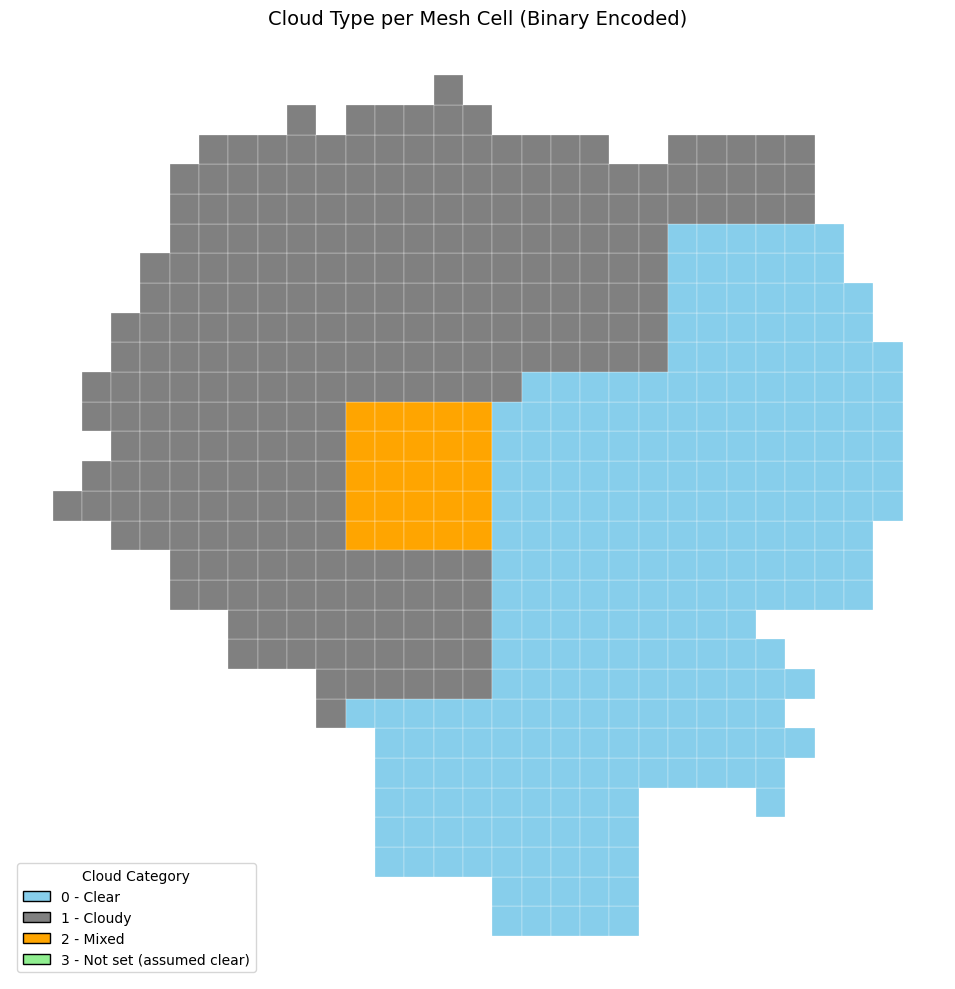

In [3]:
mesh_grid = gpd.read_file(
    DATA_PATH / "addis-mesh-data/addis-ababa-2023-01-01.gpkg", 
    layer=lyr_addis_name  # Use the correct layer name
)

plot_cloud_category(mesh_grid)

### Baghdad

In [2]:
min_lon, max_lon = 43.7, 45.0
min_lat, max_lat = 32.7, 33.8

In [ ]:
baghdad_cloud_tiff = "../data/Cloud_Baghdad" 
clip_cloud_tiff_by_bbox('baghdad', baghdad_cloud_tiff, output_path,
                      min_lon, min_lat, max_lon, max_lat,)

Processing 1/731: CloudState_Baghdad_20230101.tif
Processing 2/731: CloudState_Baghdad_20230102.tif
Processing 3/731: CloudState_Baghdad_20230103.tif
Processing 4/731: CloudState_Baghdad_20230104.tif
Processing 5/731: CloudState_Baghdad_20230105.tif
Processing 6/731: CloudState_Baghdad_20230106.tif
Processing 7/731: CloudState_Baghdad_20230107.tif
Processing 8/731: CloudState_Baghdad_20230108.tif
Processing 9/731: CloudState_Baghdad_20230109.tif
Processing 10/731: CloudState_Baghdad_20230110.tif
Processing 11/731: CloudState_Baghdad_20230111.tif
Processing 12/731: CloudState_Baghdad_20230112.tif
Processing 13/731: CloudState_Baghdad_20230113.tif
Processing 14/731: CloudState_Baghdad_20230114.tif
Processing 15/731: CloudState_Baghdad_20230115.tif
Processing 16/731: CloudState_Baghdad_20230116.tif
Processing 17/731: CloudState_Baghdad_20230117.tif
Processing 18/731: CloudState_Baghdad_20230118.tif
Processing 19/731: CloudState_Baghdad_20230119.tif
Processing 20/731: CloudState_Baghdad_20

PosixPath('/Users/ll/Documents/GitHub/air-pollution-mobility-research-project/data/baghdad-cloud-clipped')

In [5]:
baghdad_cloud_clipped = DATA_PATH / "baghdad-cloud-clipped"

fill_cloud_missing_data(
    city = 'baghdad',
    data_tiff_path = baghdad_cloud_clipped,
    output_path = DATA_PATH,
)

Processing 1/731: 2023-01-01


/Users/ll/Documents/GitHub/air-pollution-mobility-research-project/src/missingvalue.py:60: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr) if np.isnan(center) else center


Processing 2/731: 2023-01-02
Processing 3/731: 2023-01-03
Processing 4/731: 2023-01-04
Processing 5/731: 2023-01-05
Processing 6/731: 2023-01-06
Processing 7/731: 2023-01-07
Processing 8/731: 2023-01-08
Processing 9/731: 2023-01-09
Processing 10/731: 2023-01-10
Processing 11/731: 2023-01-11
Processing 12/731: 2023-01-12
Processing 13/731: 2023-01-13
Processing 14/731: 2023-01-14
Processing 15/731: 2023-01-15
Processing 16/731: 2023-01-16
Processing 17/731: 2023-01-17
Processing 18/731: 2023-01-18
Processing 19/731: 2023-01-19
Processing 20/731: 2023-01-20
Processing 21/731: 2023-01-21
Processing 22/731: 2023-01-22
Processing 23/731: 2023-01-23
Processing 24/731: 2023-01-24
Processing 25/731: 2023-01-25
Processing 26/731: 2023-01-26
Processing 27/731: 2023-01-27
Processing 28/731: 2023-01-28
Processing 29/731: 2023-01-29
Processing 30/731: 2023-01-30
Processing 31/731: 2023-01-31
Processing 32/731: 2023-02-01
Processing 33/731: 2023-02-02
Processing 34/731: 2023-02-03
Processing 35/731:

Animation

In [3]:
baghdad_cloud_tif_dir = DATA_PATH / 'baghdad-cloud-clipped'  
tiff_2_gif_cloud(baghdad_cloud_tif_dir, output_path=DATA_PATH, output_name="baghdad-cloud-animation", fps = 8)

GIF saved to: /Users/ll/Documents/GitHub/air-pollution-mobility-research-project/data/animation-output/baghdad-cloud-animation.gif


Aggregate

In [5]:
# Aggregate Iraq - Baghdad
baghdad_cloud_tif_dir = DATA_PATH / "baghdad-cloud-filled"

aggregate_cloud_data(
    data_tiff_path=baghdad_cloud_tif_dir, 
    mesh_path=baghdad_meshes_path, 
    layer_name=lyr_baghdad_name,
    feature_name="cloud_category"
)


[1/730] Aggregating cloud state: 2023-01-01
cloud_category
0.0               5999
2.0                127
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-01.gpkg
[2/730] Aggregating cloud state: 2023-01-02
cloud_category
2.0               2690
1.0               2244
0.0               1192
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-02.gpkg
[3/730] Aggregating cloud state: 2023-01-03


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-01-03.gpkg': 'baghdad-2023-01-03' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6013
2.0                113
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-03.gpkg
[4/730] Aggregating cloud state: 2023-01-04
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-04.gpkg
[5/730] Aggregating cloud state: 2023-01-05
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-05.gpkg
[6/730] Aggregating cloud state: 2023-01-06
cloud_category
1.0               5946
0.0                180
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-06.gpkg
[7/730] Aggregating cloud state: 2023-01-07
cloud_category
1.0               6037
2.0                 87
0.0                  2
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-07.gpkg
[8/730] Aggregating cloud state: 2023-01-08
cloud_category
1.0               5261
0.0                825
2.0                 40
Name

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-01-12.gpkg': 'baghdad-2023-01-12' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               4812
1.0               1072
2.0                242
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-12.gpkg
[13/730] Aggregating cloud state: 2023-01-13
cloud_category
0.0               3998
1.0               1380
2.0                748
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-13.gpkg
[14/730] Aggregating cloud state: 2023-01-14
cloud_category
1.0               6074
0.0                 52
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-14.gpkg
[15/730] Aggregating cloud state: 2023-01-15
cloud_category
1.0               4597
0.0               1444
2.0                 85
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-15.gpkg
[16/730] Aggregating cloud state: 2023-01-16
cloud_category
1.0               3446
2.0               2274
0.0                406
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-16.gpkg
[17/730] Aggr

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-01-25.gpkg': 'baghdad-2023-01-25' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
2.0               3424
0.0               1679
1.0               1023
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-25.gpkg
[26/730] Aggregating cloud state: 2023-01-26
cloud_category
0.000000          4646
2.000000          1411
0.764706            30
1.000000            15
0.487805            13
0.347826            11
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-26.gpkg
[27/730] Aggregating cloud state: 2023-01-27
cloud_category
2.0               3339
0.0               2079
1.0                708
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-27.gpkg
[28/730] Aggregating cloud state: 2023-01-28


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-01-28.gpkg': 'baghdad-2023-01-28' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.00000           3833
2.00000           1593
0.00000            689
1.26087             11
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-28.gpkg
[29/730] Aggregating cloud state: 2023-01-29
cloud_category
0.000000          4140
2.000000          1330
1.000000           626
0.470588            30
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-29.gpkg
[30/730] Aggregating cloud state: 2023-01-30
cloud_category
1.0               4369
2.0               1444
0.0                313
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-30.gpkg
[31/730] Aggregating cloud state: 2023-01-31
cloud_category
1.0               5509
0.0                567
2.0                 50
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-01-31.gpkg
[32/730] Aggregating cloud state: 2023-02-01
cloud_category
0.0               3133
2.0               2993
Name: count, dtype: int64
Layer 'grid_badhdad' wr

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-02-06.gpkg': 'baghdad-2023-02-06' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               5635
2.0                294
0.0                197
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-06.gpkg
[38/730] Aggregating cloud state: 2023-02-07
cloud_category
0.0               4293
2.0               1039
1.0                794
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-07.gpkg
[39/730] Aggregating cloud state: 2023-02-08
cloud_category
1.0               5886
0.0                179
2.0                 61
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-08.gpkg
[40/730] Aggregating cloud state: 2023-02-09
cloud_category
0.0               3785
1.0               2199
2.0                142
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-09.gpkg
[41/730] Aggregating cloud state: 2023-02-10
cloud_category
2.0               3187
0.0               1651
1.0               1288
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-0

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-02-12.gpkg': 'baghdad-2023-02-12' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               3037
0.0               1998
2.0               1091
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-12.gpkg
[44/730] Aggregating cloud state: 2023-02-13
cloud_category
1.0               4425
2.0               1351
0.0                350
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-13.gpkg
[45/730] Aggregating cloud state: 2023-02-14
cloud_category
1.0               4959
0.0               1110
2.0                 57
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-14.gpkg
[46/730] Aggregating cloud state: 2023-02-15
cloud_category
2.0               3164
1.0               2532
0.0                430
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-15.gpkg
[47/730] Aggregating cloud state: 2023-02-16
cloud_category
0.0               5952
2.0                174
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-16.gpkg
[48/730] Aggr

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-02-17.gpkg': 'baghdad-2023-02-17' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
2.0               3561
0.0               2535
1.0                 30
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-17.gpkg
[49/730] Aggregating cloud state: 2023-02-18
cloud_category
0.000000          5972
2.000000           119
0.053333            20
1.000000            15
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-18.gpkg
[50/730] Aggregating cloud state: 2023-02-19
cloud_category
0.0               5577
2.0                549
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-19.gpkg
[51/730] Aggregating cloud state: 2023-02-20


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-02-20.gpkg': 'baghdad-2023-02-20' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
2.0               4196
1.0               1584
0.0                346
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-20.gpkg
[52/730] Aggregating cloud state: 2023-02-21
cloud_category
0.00000           4942
2.00000           1175
0.42623              9
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-21.gpkg
[53/730] Aggregating cloud state: 2023-02-22
cloud_category
2.0               4456
0.0               1648
1.0                 22
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-22.gpkg
[54/730] Aggregating cloud state: 2023-02-23
cloud_category
0.0               5885
2.0                241
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-23.gpkg
[55/730] Aggregating cloud state: 2023-02-24
cloud_category
0.0               4621
2.0               1493
1.0                 12
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-24.gpkg
[56/730] Aggr

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-02-25.gpkg': 'baghdad-2023-02-25' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.000000          4306
2.000000          1677
1.000000            88
0.728571            35
0.867925            20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-25.gpkg
[57/730] Aggregating cloud state: 2023-02-26
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-26.gpkg
[58/730] Aggregating cloud state: 2023-02-27
cloud_category
2.0               5547
0.0                438
1.0                141
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-27.gpkg
[59/730] Aggregating cloud state: 2023-02-28
cloud_category
0.0               6101
2.0                 25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-02-28.gpkg
[60/730] Aggregating cloud state: 2023-03-01
cloud_category
0.0               5835
2.0                291
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-01.gpkg
[61/730] Aggregating cloud state: 20

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-03-05.gpkg': 'baghdad-2023-03-05' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               2870
0.0               1630
2.0               1626
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-05.gpkg
[65/730] Aggregating cloud state: 2023-03-06
cloud_category
2.0               5417
0.0                624
1.0                 85
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-06.gpkg
[66/730] Aggregating cloud state: 2023-03-07
cloud_category
0.0               3593
1.0               1943
2.0                590
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-07.gpkg
[67/730] Aggregating cloud state: 2023-03-08


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-03-08.gpkg': 'baghdad-2023-03-08' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-08.gpkg
[68/730] Aggregating cloud state: 2023-03-09
cloud_category
0.0               3282
1.0               2683
2.0                161
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-09.gpkg
[69/730] Aggregating cloud state: 2023-03-10
cloud_category
0.0               5567
2.0                559
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-10.gpkg
[70/730] Aggregating cloud state: 2023-03-11
cloud_category
0.0               6101
2.0                 25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-11.gpkg
[71/730] Aggregating cloud state: 2023-03-12
cloud_category
0.0               4730
1.0               1048
2.0                348
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-12.gpkg
[72/730] Aggregating cloud state: 2023-03-13
cloud_category
1.0               5476

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-03-14.gpkg': 'baghdad-2023-03-14' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               3411
0.0               2062
2.0                653
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-14.gpkg
[74/730] Aggregating cloud state: 2023-03-15
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-15.gpkg
[75/730] Aggregating cloud state: 2023-03-16
cloud_category
0.0               6082
2.0                 44
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-16.gpkg
[76/730] Aggregating cloud state: 2023-03-17
cloud_category
0.0               5930
2.0                171
1.0                 25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-17.gpkg
[77/730] Aggregating cloud state: 2023-03-18
cloud_category
0.000000          5947
2.000000           135
0.121622            25
1.000000            19
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-18.gpkg
[78/730] Aggregating cloud state: 20

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-03-19.gpkg': 'baghdad-2023-03-19' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-19.gpkg
[79/730] Aggregating cloud state: 2023-03-20
cloud_category
0.0               3815
1.0               2286
2.0                 25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-20.gpkg
[80/730] Aggregating cloud state: 2023-03-21
cloud_category
1.0               3797
0.0               2212
2.0                117
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-21.gpkg
[81/730] Aggregating cloud state: 2023-03-22
cloud_category
1.0               2611
0.0               1832
2.0               1683
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-22.gpkg
[82/730] Aggregating cloud state: 2023-03-23


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-03-23.gpkg': 'baghdad-2023-03-23' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               4660
1.0                815
2.0                651
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-23.gpkg
[83/730] Aggregating cloud state: 2023-03-24
cloud_category
0.000000          5939
2.000000           137
0.026316            25
0.028986            25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-24.gpkg
[84/730] Aggregating cloud state: 2023-03-25
cloud_category
0.000000          6086
0.028571            20
2.000000            20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-25.gpkg
[85/730] Aggregating cloud state: 2023-03-26


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-03-26.gpkg': 'baghdad-2023-03-26' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               3140
0.0               1803
2.0               1183
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-26.gpkg
[86/730] Aggregating cloud state: 2023-03-27
cloud_category
1.0               5733
0.0                216
2.0                177
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-27.gpkg
[87/730] Aggregating cloud state: 2023-03-28
cloud_category
0.0               5301
2.0                582
1.0                243
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-28.gpkg
[88/730] Aggregating cloud state: 2023-03-29
cloud_category
0.0               6101
2.0                 25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-29.gpkg
[89/730] Aggregating cloud state: 2023-03-30
cloud_category
0.000000          4959
2.000000          1142
0.783784            25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-03-30.gpkg
[90/730] Aggr

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-04-11.gpkg': 'baghdad-2023-04-11' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               4014
1.0               2084
2.0                 28
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-11.gpkg
[102/730] Aggregating cloud state: 2023-04-12
cloud_category
1.0               6064
0.0                 38
2.0                 24
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-12.gpkg
[103/730] Aggregating cloud state: 2023-04-13
cloud_category
0.0               5792
2.0                189
1.0                145
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-13.gpkg
[104/730] Aggregating cloud state: 2023-04-14


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-04-14.gpkg': 'baghdad-2023-04-14' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5672
2.0                351
1.0                103
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-14.gpkg
[105/730] Aggregating cloud state: 2023-04-15
cloud_category
0.0               6037
2.0                 89
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-15.gpkg
[106/730] Aggregating cloud state: 2023-04-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-16.gpkg
[107/730] Aggregating cloud state: 2023-04-17
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-17.gpkg
[108/730] Aggregating cloud state: 2023-04-18
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-18.gpkg
[109/730] Aggregating cloud state: 2023-04-19
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghd

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-04-23.gpkg': 'baghdad-2023-04-23' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6105
1.0                 21
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-23.gpkg
[114/730] Aggregating cloud state: 2023-04-24
cloud_category
1.0               6117
0.0                  9
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-24.gpkg
[115/730] Aggregating cloud state: 2023-04-25
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-25.gpkg
[116/730] Aggregating cloud state: 2023-04-26


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-04-26.gpkg': 'baghdad-2023-04-26' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-26.gpkg
[117/730] Aggregating cloud state: 2023-04-27
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-27.gpkg
[118/730] Aggregating cloud state: 2023-04-28
cloud_category
0.0               6120
1.0                  6
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-28.gpkg
[119/730] Aggregating cloud state: 2023-04-29
cloud_category
0.0               5659
2.0                456
1.0                 11
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-29.gpkg
[120/730] Aggregating cloud state: 2023-04-30
cloud_category
0.0               6065
1.0                 49
2.0                 12
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-04-30.gpkg
[121/730] Aggregating cloud state: 2023-05-01
cloud_category
0.0               6126
Name: count, dtyp

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-05-03.gpkg': 'baghdad-2023-05-03' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-03.gpkg
[124/730] Aggregating cloud state: 2023-05-04
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-04.gpkg
[125/730] Aggregating cloud state: 2023-05-05
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-05.gpkg
[126/730] Aggregating cloud state: 2023-05-06
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-06.gpkg
[127/730] Aggregating cloud state: 2023-05-07
cloud_category
0.0               5230
1.0                896
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-07.gpkg
[128/730] Aggregating cloud state: 2023-05-08
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-08.gpkg
[129/730] Aggregating cloud

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-05-12.gpkg': 'baghdad-2023-05-12' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-12.gpkg
[133/730] Aggregating cloud state: 2023-05-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-13.gpkg
[134/730] Aggregating cloud state: 2023-05-14
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-14.gpkg
[135/730] Aggregating cloud state: 2023-05-15
cloud_category
0.000000          5760
1.000000           251
2.000000            70
0.025316            25
0.056338            20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-15.gpkg
[136/730] Aggregating cloud state: 2023-05-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-16.gpkg
[137/730] Aggregating cloud state: 2023-05-17


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-05-17.gpkg': 'baghdad-2023-05-17' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               5381
0.0                449
2.0                296
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-17.gpkg
[138/730] Aggregating cloud state: 2023-05-18
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-18.gpkg
[139/730] Aggregating cloud state: 2023-05-19
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-19.gpkg
[140/730] Aggregating cloud state: 2023-05-20


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-05-20.gpkg': 'baghdad-2023-05-20' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               4963
0.0                786
2.0                377
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-20.gpkg
[141/730] Aggregating cloud state: 2023-05-21
cloud_category
0.0               6106
1.0                 20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-21.gpkg
[142/730] Aggregating cloud state: 2023-05-22
cloud_category
0.000000          5977
2.000000            74
0.084507            25
0.092308            20
0.109091            18
0.115385            12
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-22.gpkg
[143/730] Aggregating cloud state: 2023-05-23
cloud_category
0.0               6118
1.0                  8
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-23.gpkg
[144/730] Aggregating cloud state: 2023-05-24
cloud_category
0.00              4908
1.00              1071
2.00               122
0.28                25
Name: count, dtype: in

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-05-25.gpkg': 'baghdad-2023-05-25' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               5628
0.0                438
2.0                 60
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-25.gpkg
[146/730] Aggregating cloud state: 2023-05-26
cloud_category
0.0               5194
1.0                909
2.0                 23
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-26.gpkg
[147/730] Aggregating cloud state: 2023-05-27
cloud_category
1.0               3468
0.0               2550
2.0                108
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-27.gpkg
[148/730] Aggregating cloud state: 2023-05-28


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-05-28.gpkg': 'baghdad-2023-05-28' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               5423
0.0                648
2.0                 55
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-28.gpkg
[149/730] Aggregating cloud state: 2023-05-29
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-29.gpkg
[150/730] Aggregating cloud state: 2023-05-30
cloud_category
0.0               5975
1.0                151
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-30.gpkg
[151/730] Aggregating cloud state: 2023-05-31
cloud_category
0.0               4986
1.0               1140
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-05-31.gpkg
[152/730] Aggregating cloud state: 2023-06-01
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-01.gpkg
[153/730] Aggregating cloud state: 2023-06-02
cloud_category
0.0               5565
1.0                366
2.0              

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-06-06.gpkg': 'baghdad-2023-06-06' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5784
1.0                342
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-06.gpkg
[158/730] Aggregating cloud state: 2023-06-07
cloud_category
0.0               5792
1.0                334
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-07.gpkg
[159/730] Aggregating cloud state: 2023-06-08
cloud_category
0.0               6076
1.0                 50
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-08.gpkg
[160/730] Aggregating cloud state: 2023-06-09
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-09.gpkg
[161/730] Aggregating cloud state: 2023-06-10
cloud_category
1.0               4343
0.0               1638
2.0                145
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-10.gpkg
[162/730] Aggregating cloud state: 2023-06-11
cloud_category
0.0               6126
Name: count, dtyp

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-06-12.gpkg': 'baghdad-2023-06-12' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5273
1.0                853
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-12.gpkg
[164/730] Aggregating cloud state: 2023-06-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-13.gpkg
[165/730] Aggregating cloud state: 2023-06-14
cloud_category
0.0               5076
1.0               1030
2.0                 20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-14.gpkg
[166/730] Aggregating cloud state: 2023-06-15
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-15.gpkg
[167/730] Aggregating cloud state: 2023-06-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-16.gpkg
[168/730] Aggregating cloud state: 2023-06-17


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-06-17.gpkg': 'baghdad-2023-06-17' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-17.gpkg
[169/730] Aggregating cloud state: 2023-06-18
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-18.gpkg
[170/730] Aggregating cloud state: 2023-06-19
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-19.gpkg
[171/730] Aggregating cloud state: 2023-06-20


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-06-20.gpkg': 'baghdad-2023-06-20' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-20.gpkg
[172/730] Aggregating cloud state: 2023-06-21
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-21.gpkg
[173/730] Aggregating cloud state: 2023-06-22
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-22.gpkg
[174/730] Aggregating cloud state: 2023-06-23
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-23.gpkg
[175/730] Aggregating cloud state: 2023-06-24
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-24.gpkg
[176/730] Aggregating cloud state: 2023-06-25


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-06-25.gpkg': 'baghdad-2023-06-25' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-25.gpkg
[177/730] Aggregating cloud state: 2023-06-26
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-26.gpkg
[178/730] Aggregating cloud state: 2023-06-27
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-27.gpkg
[179/730] Aggregating cloud state: 2023-06-28
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-28.gpkg
[180/730] Aggregating cloud state: 2023-06-29
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-29.gpkg
[181/730] Aggregating cloud state: 2023-06-30
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-06-30.gpkg
[182/730] Aggregating cloud state: 2023-07-01
clou

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-07-05.gpkg': 'baghdad-2023-07-05' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-05.gpkg
[187/730] Aggregating cloud state: 2023-07-06
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-06.gpkg
[188/730] Aggregating cloud state: 2023-07-07
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-07.gpkg
[189/730] Aggregating cloud state: 2023-07-08


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-07-08.gpkg': 'baghdad-2023-07-08' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-08.gpkg
[190/730] Aggregating cloud state: 2023-07-09
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-09.gpkg
[191/730] Aggregating cloud state: 2023-07-10
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-10.gpkg
[192/730] Aggregating cloud state: 2023-07-11


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-07-11.gpkg': 'baghdad-2023-07-11' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-11.gpkg
[193/730] Aggregating cloud state: 2023-07-12
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-12.gpkg
[194/730] Aggregating cloud state: 2023-07-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-13.gpkg
[195/730] Aggregating cloud state: 2023-07-14


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-07-14.gpkg': 'baghdad-2023-07-14' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-14.gpkg
[196/730] Aggregating cloud state: 2023-07-15
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-15.gpkg
[197/730] Aggregating cloud state: 2023-07-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-16.gpkg
[198/730] Aggregating cloud state: 2023-07-17
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-17.gpkg
[199/730] Aggregating cloud state: 2023-07-18
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-18.gpkg
[200/730] Aggregating cloud state: 2023-07-19


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-07-19.gpkg': 'baghdad-2023-07-19' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-19.gpkg
[201/730] Aggregating cloud state: 2023-07-20
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-20.gpkg
[202/730] Aggregating cloud state: 2023-07-21
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-21.gpkg
[203/730] Aggregating cloud state: 2023-07-22
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-22.gpkg
[204/730] Aggregating cloud state: 2023-07-23


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-07-23.gpkg': 'baghdad-2023-07-23' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-23.gpkg
[205/730] Aggregating cloud state: 2023-07-24
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-24.gpkg
[206/730] Aggregating cloud state: 2023-07-25
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-25.gpkg
[207/730] Aggregating cloud state: 2023-07-26


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-07-26.gpkg': 'baghdad-2023-07-26' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-26.gpkg
[208/730] Aggregating cloud state: 2023-07-27
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-27.gpkg
[209/730] Aggregating cloud state: 2023-07-28
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-28.gpkg
[210/730] Aggregating cloud state: 2023-07-29
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-29.gpkg
[211/730] Aggregating cloud state: 2023-07-30
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-30.gpkg
[212/730] Aggregating cloud state: 2023-07-31
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-07-31.gpkg
[213/730] Aggregating cloud state: 2023-08-01


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-08-01.gpkg': 'baghdad-2023-08-01' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-01.gpkg
[214/730] Aggregating cloud state: 2023-08-02
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-02.gpkg
[215/730] Aggregating cloud state: 2023-08-03
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-03.gpkg
[216/730] Aggregating cloud state: 2023-08-04
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-04.gpkg
[217/730] Aggregating cloud state: 2023-08-05
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-05.gpkg
[218/730] Aggregating cloud state: 2023-08-06
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-06.gpkg
[219/730] Aggregating cloud state: 2023-08-07
clou

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-08-09.gpkg': 'baghdad-2023-08-09' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-09.gpkg
[222/730] Aggregating cloud state: 2023-08-10


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-08-10.gpkg': 'baghdad-2023-08-10' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-10.gpkg
[223/730] Aggregating cloud state: 2023-08-11
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-11.gpkg
[224/730] Aggregating cloud state: 2023-08-12
cloud_category
0.000000          5223
1.000000           853
0.054054            25
0.138889            25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-12.gpkg
[225/730] Aggregating cloud state: 2023-08-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-13.gpkg
[226/730] Aggregating cloud state: 2023-08-14
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-14.gpkg
[227/730] Aggregating cloud state: 2023-08-15
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghd

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-08-27.gpkg': 'baghdad-2023-08-27' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-27.gpkg
[240/730] Aggregating cloud state: 2023-08-28
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-28.gpkg
[241/730] Aggregating cloud state: 2023-08-29
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-29.gpkg
[242/730] Aggregating cloud state: 2023-08-30
cloud_category
0.0               6084
1.0                 42
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-30.gpkg
[243/730] Aggregating cloud state: 2023-08-31
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-08-31.gpkg
[244/730] Aggregating cloud state: 2023-09-01
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-01.gpkg
[245/730] Aggregating cloud

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-09-02.gpkg': 'baghdad-2023-09-02' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-02.gpkg
[246/730] Aggregating cloud state: 2023-09-03
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-03.gpkg
[247/730] Aggregating cloud state: 2023-09-04
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-04.gpkg
[248/730] Aggregating cloud state: 2023-09-05
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-05.gpkg
[249/730] Aggregating cloud state: 2023-09-06
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-06.gpkg
[250/730] Aggregating cloud state: 2023-09-07
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-07.gpkg
[251/730] Aggregating cloud state: 2023-09-08
clou

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-09-13.gpkg': 'baghdad-2023-09-13' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5070
1.0               1056
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-13.gpkg
[257/730] Aggregating cloud state: 2023-09-14
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-14.gpkg
[258/730] Aggregating cloud state: 2023-09-15
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-15.gpkg
[259/730] Aggregating cloud state: 2023-09-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-16.gpkg
[260/730] Aggregating cloud state: 2023-09-17
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-17.gpkg
[261/730] Aggregating cloud state: 2023-09-18
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-18.gpkg
[262/730] Aggregating cloud

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-09-24.gpkg': 'baghdad-2023-09-24' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-24.gpkg
[268/730] Aggregating cloud state: 2023-09-25
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-25.gpkg
[269/730] Aggregating cloud state: 2023-09-26
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-26.gpkg
[270/730] Aggregating cloud state: 2023-09-27
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-27.gpkg
[271/730] Aggregating cloud state: 2023-09-28
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-28.gpkg
[272/730] Aggregating cloud state: 2023-09-29


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-09-29.gpkg': 'baghdad-2023-09-29' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-29.gpkg
[273/730] Aggregating cloud state: 2023-09-30
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-09-30.gpkg
[274/730] Aggregating cloud state: 2023-10-01
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-01.gpkg
[275/730] Aggregating cloud state: 2023-10-02
cloud_category
1.0               5954
0.0                156
2.0                 16
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-02.gpkg
[276/730] Aggregating cloud state: 2023-10-03
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-03.gpkg
[277/730] Aggregating cloud state: 2023-10-04
cloud_category
1.0               5674
0.0                357
2.0                 95
Name: count, dtype: int64
Layer 'grid_ba

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-10-05.gpkg': 'baghdad-2023-10-05' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               4588
2.0               1223
1.0                315
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-05.gpkg
[279/730] Aggregating cloud state: 2023-10-06
cloud_category
1.0               3313
0.0               2813
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-06.gpkg
[280/730] Aggregating cloud state: 2023-10-07
cloud_category
0.000000          5447
1.000000           567
2.000000            88
0.020408            24
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-07.gpkg
[281/730] Aggregating cloud state: 2023-10-08


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-10-08.gpkg': 'baghdad-2023-10-08' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               3764
1.0               1994
2.0                368
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-08.gpkg
[282/730] Aggregating cloud state: 2023-10-09
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-09.gpkg
[283/730] Aggregating cloud state: 2023-10-10
cloud_category
1.0               3986
0.0               1529
2.0                611
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-10.gpkg
[284/730] Aggregating cloud state: 2023-10-11


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-10-11.gpkg': 'baghdad-2023-10-11' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5849
1.0                202
2.0                 75
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-11.gpkg
[285/730] Aggregating cloud state: 2023-10-12
cloud_category
1.0               3798
0.0               1499
2.0                829
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-12.gpkg
[286/730] Aggregating cloud state: 2023-10-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-13.gpkg
[287/730] Aggregating cloud state: 2023-10-14


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-10-14.gpkg': 'baghdad-2023-10-14' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-14.gpkg
[288/730] Aggregating cloud state: 2023-10-15
cloud_category
1.0               4887
0.0               1130
2.0                109
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-15.gpkg
[289/730] Aggregating cloud state: 2023-10-16
cloud_category
NaN               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-16.gpkg
[290/730] Aggregating cloud state: 2023-10-17
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-17.gpkg
[291/730] Aggregating cloud state: 2023-10-18
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-18.gpkg
[292/730] Aggregating cloud state: 2023-10-19


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-10-19.gpkg': 'baghdad-2023-10-19' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
2.000000          4357
0.000000          1623
1.000000           116
1.275362            30
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-19.gpkg
[293/730] Aggregating cloud state: 2023-10-20
cloud_category
0.0               5761
2.0                365
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-20.gpkg
[294/730] Aggregating cloud state: 2023-10-21
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-21.gpkg
[295/730] Aggregating cloud state: 2023-10-22
cloud_category
1.0               5456
0.0                670
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-22.gpkg
[296/730] Aggregating cloud state: 2023-10-23


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-10-23.gpkg': 'baghdad-2023-10-23' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5536
1.0                545
2.0                 45
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-23.gpkg
[297/730] Aggregating cloud state: 2023-10-24
cloud_category
1.0               6105
2.0                 21
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-24.gpkg
[298/730] Aggregating cloud state: 2023-10-25
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-25.gpkg
[299/730] Aggregating cloud state: 2023-10-26


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-10-26.gpkg': 'baghdad-2023-10-26' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               4075
2.0               1905
1.0                146
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-26.gpkg
[300/730] Aggregating cloud state: 2023-10-27
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-27.gpkg
[301/730] Aggregating cloud state: 2023-10-28
cloud_category
0.0               4546
1.0               1147
2.0                433
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-28.gpkg
[302/730] Aggregating cloud state: 2023-10-29
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-29.gpkg
[303/730] Aggregating cloud state: 2023-10-30
cloud_category
1.0               5964
0.0                151
2.0                 11
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-10-30.gpkg
[304/730] Aggregating cloud state: 2023-10-31
cloud_category
1.0              

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-11-06.gpkg': 'baghdad-2023-11-06' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-06.gpkg
[311/730] Aggregating cloud state: 2023-11-07
cloud_category
2.0               5838
0.0                288
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-07.gpkg
[312/730] Aggregating cloud state: 2023-11-08
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-08.gpkg
[313/730] Aggregating cloud state: 2023-11-09
cloud_category
0.0               6034
2.0                 92
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-09.gpkg
[314/730] Aggregating cloud state: 2023-11-10
cloud_category
0.0               3661
1.0               2325
2.0                140
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-10.gpkg
[315/730] Aggregating cloud state: 2023-11-11
cloud_category
2.0               3586
0.0               1552
1.0              

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-11-12.gpkg': 'baghdad-2023-11-12' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               6117
0.0                  9
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-12.gpkg
[317/730] Aggregating cloud state: 2023-11-13
cloud_category
NaN               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-13.gpkg
[318/730] Aggregating cloud state: 2023-11-14
cloud_category
1.0               5245
2.0                634
0.0                247
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-14.gpkg
[319/730] Aggregating cloud state: 2023-11-15
cloud_category
1.0               6037
2.0                 54
0.0                 35
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-15.gpkg
[320/730] Aggregating cloud state: 2023-11-16
cloud_category
1.0               6004
0.0                 74
2.0                 48
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-16.gpkg
[321/730] Aggregating cloud state: 2023-11-17


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-11-17.gpkg': 'baghdad-2023-11-17' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               3653
2.0               2253
1.0                220
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-17.gpkg
[322/730] Aggregating cloud state: 2023-11-18
cloud_category
0.0               3927
2.0               2199
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-18.gpkg
[323/730] Aggregating cloud state: 2023-11-19
cloud_category
1.0000            3346
0.0000            1947
2.0000             808
0.9125              25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-19.gpkg
[324/730] Aggregating cloud state: 2023-11-20


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-11-20.gpkg': 'baghdad-2023-11-20' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6076
1.0                 25
2.0                 25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-20.gpkg
[325/730] Aggregating cloud state: 2023-11-21
cloud_category
1.0               4055
2.0               1379
0.0                692
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-21.gpkg
[326/730] Aggregating cloud state: 2023-11-22
cloud_category
0.0               4162
1.0               1277
2.0                687
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-22.gpkg
[327/730] Aggregating cloud state: 2023-11-23
cloud_category
1.0               6042
2.0                 84
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-23.gpkg
[328/730] Aggregating cloud state: 2023-11-24
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-24.gpkg
[329/730] Aggregating cloud state: 2023-11-25


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-11-25.gpkg': 'baghdad-2023-11-25' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               4972
2.0                982
0.0                172
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-25.gpkg
[330/730] Aggregating cloud state: 2023-11-26
cloud_category
1.0               6116
2.0                 10
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-26.gpkg
[331/730] Aggregating cloud state: 2023-11-27
cloud_category
0.0               5673
2.0                453
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-27.gpkg
[332/730] Aggregating cloud state: 2023-11-28
cloud_category
1.0               3286
2.0               2370
0.0                470
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-28.gpkg
[333/730] Aggregating cloud state: 2023-11-29
cloud_category
1.0               5779
0.0                302
2.0                 45
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-11-29.gpkg
[334/730] Aggregating cloud stat

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-12-03.gpkg': 'baghdad-2023-12-03' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
2.0               4378
1.0               1288
0.0                460
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-03.gpkg
[338/730] Aggregating cloud state: 2023-12-04
cloud_category
0.0               6051
2.0                 75
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-04.gpkg
[339/730] Aggregating cloud state: 2023-12-05
cloud_category
2.0               5875
0.0                251
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-05.gpkg
[340/730] Aggregating cloud state: 2023-12-06
cloud_category
0.000000          5828
2.000000           250
1.000000            25
0.290909            19
0.372093             4
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-06.gpkg
[341/730] Aggregating cloud state: 2023-12-07
cloud_category
2.0               3503
0.0               2302
1.0                321
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-20

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-12-12.gpkg': 'baghdad-2023-12-12' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-12.gpkg
[347/730] Aggregating cloud state: 2023-12-13
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-13.gpkg
[348/730] Aggregating cloud state: 2023-12-14
cloud_category
0.0               4487
2.0               1557
1.0                 82
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-14.gpkg
[349/730] Aggregating cloud state: 2023-12-15
cloud_category
1.0               5823
0.0                283
2.0                 20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-15.gpkg
[350/730] Aggregating cloud state: 2023-12-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-16.gpkg
[351/730] Aggregating cloud state: 2023-12-17


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-12-17.gpkg': 'baghdad-2023-12-17' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
2.0               3441
1.0               2209
0.0                476
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-17.gpkg
[352/730] Aggregating cloud state: 2023-12-18
cloud_category
0.0               3431
1.0               2116
2.0                579
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-18.gpkg
[353/730] Aggregating cloud state: 2023-12-19
cloud_category
2.0               2465
1.0               2067
0.0               1594
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-19.gpkg
[354/730] Aggregating cloud state: 2023-12-20


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-12-20.gpkg': 'baghdad-2023-12-20' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.000000          4501
1.000000           968
2.000000           622
0.308824            35
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-20.gpkg
[355/730] Aggregating cloud state: 2023-12-21
cloud_category
1.0               4611
0.0               1272
2.0                243
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-21.gpkg
[356/730] Aggregating cloud state: 2023-12-22
cloud_category
1.000000          5866
0.000000           131
2.000000            89
0.971429            40
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-22.gpkg
[357/730] Aggregating cloud state: 2023-12-23
cloud_category
0.0               6081
2.0                 45
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-23.gpkg
[358/730] Aggregating cloud state: 2023-12-24
cloud_category
1.0               6061
0.0                 35
2.0                 30
Name: count, dtype: int64
Layer 'grid_badhdad

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-12-25.gpkg': 'baghdad-2023-12-25' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6081
2.0                 45
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-25.gpkg
[360/730] Aggregating cloud state: 2023-12-26
cloud_category
0.0               4641
2.0               1485
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-26.gpkg
[361/730] Aggregating cloud state: 2023-12-27
cloud_category
0.000000          6027
1.000000            55
0.052632            20
2.000000            20
0.045455             4
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-27.gpkg
[362/730] Aggregating cloud state: 2023-12-28


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2023-12-28.gpkg': 'baghdad-2023-12-28' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-28.gpkg
[363/730] Aggregating cloud state: 2023-12-29
cloud_category
1.0               3341
2.0               2341
0.0                444
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-29.gpkg
[364/730] Aggregating cloud state: 2023-12-30
cloud_category
0.0               5266
1.0                731
2.0                129
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-30.gpkg
[365/730] Aggregating cloud state: 2023-12-31
cloud_category
2.0               2972
0.0               2304
1.0                850
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2023-12-31.gpkg
[366/730] Aggregating cloud state: 2024-01-01
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-01.gpkg
[367/730] Aggregating cloud state: 2024-01-02
cloud_category
1.0              

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-01-08.gpkg': 'baghdad-2024-01-08' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5421
1.0                636
2.0                 69
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-08.gpkg
[374/730] Aggregating cloud state: 2024-01-09
cloud_category
1.0               5542
0.0                563
2.0                 21
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-09.gpkg
[375/730] Aggregating cloud state: 2024-01-10
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-10.gpkg
[376/730] Aggregating cloud state: 2024-01-11


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-01-11.gpkg': 'baghdad-2024-01-11' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               6013
0.0                113
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-11.gpkg
[377/730] Aggregating cloud state: 2024-01-12
cloud_category
2.0               3236
1.0               1574
0.0               1316
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-12.gpkg
[378/730] Aggregating cloud state: 2024-01-13
cloud_category
0.0               3765
1.0               2189
2.0                172
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-13.gpkg
[379/730] Aggregating cloud state: 2024-01-14


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-01-14.gpkg': 'baghdad-2024-01-14' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               4291
2.0               1835
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-14.gpkg
[380/730] Aggregating cloud state: 2024-01-15
cloud_category
0.000000          5685
1.000000           416
0.155844            25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-15.gpkg
[381/730] Aggregating cloud state: 2024-01-16
cloud_category
0.0               6025
2.0                101
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-16.gpkg
[382/730] Aggregating cloud state: 2024-01-17
cloud_category
1.0               6031
0.0                 72
2.0                 23
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-17.gpkg
[383/730] Aggregating cloud state: 2024-01-18
cloud_category
0.0               6106
2.0                 20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-18.gpkg
[384/730] Aggregating cloud state: 2024-01-19
cloud_cat

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-01-26.gpkg': 'baghdad-2024-01-26' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-26.gpkg
[392/730] Aggregating cloud state: 2024-01-27
cloud_category
0.0               4589
1.0               1422
2.0                115
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-27.gpkg
[393/730] Aggregating cloud state: 2024-01-28
cloud_category
0.0               6067
1.0                 39
2.0                 20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-28.gpkg
[394/730] Aggregating cloud state: 2024-01-29
cloud_category
1.0               3632
2.0               2112
0.0                382
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-29.gpkg
[395/730] Aggregating cloud state: 2024-01-30
cloud_category
0.0               4155
1.0               1746
2.0                225
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-01-30.gpkg
[396/730] Aggregating cloud stat

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-02-05.gpkg': 'baghdad-2024-02-05' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               3606
2.0               1917
0.0                603
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-05.gpkg
[402/730] Aggregating cloud state: 2024-02-06
cloud_category
0.0               4852
1.0               1224
2.0                 50
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-06.gpkg
[403/730] Aggregating cloud state: 2024-02-07
cloud_category
0.0               3244
2.0               2882
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-07.gpkg
[404/730] Aggregating cloud state: 2024-02-08


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-02-08.gpkg': 'baghdad-2024-02-08' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6102
2.0                 24
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-08.gpkg
[405/730] Aggregating cloud state: 2024-02-09
cloud_category
0.0               5400
1.0                431
2.0                295
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-09.gpkg
[406/730] Aggregating cloud state: 2024-02-10
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-10.gpkg
[407/730] Aggregating cloud state: 2024-02-11
cloud_category
0.0               6106
2.0                 20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-11.gpkg
[408/730] Aggregating cloud state: 2024-02-12
cloud_category
2.0               4174
0.0               1395
1.0                557
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-12.gpkg
[409/730] Aggregating cloud state: 2024-02-13
cloud_category
1.0              

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-02-14.gpkg': 'baghdad-2024-02-14' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               6051
0.0                 50
2.0                 25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-14.gpkg
[411/730] Aggregating cloud state: 2024-02-15
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-15.gpkg
[412/730] Aggregating cloud state: 2024-02-16
cloud_category
1.0               6123
0.0                  3
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-16.gpkg
[413/730] Aggregating cloud state: 2024-02-17
cloud_category
1.0               4644
0.0                861
2.0                621
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-17.gpkg
[414/730] Aggregating cloud state: 2024-02-18
cloud_category
0.0               6027
2.0                 50
1.0                 49
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-18.gpkg
[415/730] Aggregating cloud state: 2024-02-19


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-02-19.gpkg': 'baghdad-2024-02-19' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               3139
1.0               1637
2.0               1350
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-19.gpkg
[416/730] Aggregating cloud state: 2024-02-20
cloud_category
0.000000          5574
1.000000           299
2.000000           215
0.025974            25
0.090909            13
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-20.gpkg
[417/730] Aggregating cloud state: 2024-02-21
cloud_category
0.0               3231
1.0               2704
2.0                191
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-21.gpkg
[418/730] Aggregating cloud state: 2024-02-22
cloud_category
2.0               5027
1.0                566
0.0                504
1.6                 29
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-22.gpkg
[419/730] Aggregating cloud state: 2024-02-23


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-02-23.gpkg': 'baghdad-2024-02-23' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               6124
2.0                  2
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-23.gpkg
[420/730] Aggregating cloud state: 2024-02-24
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-24.gpkg
[421/730] Aggregating cloud state: 2024-02-25
cloud_category
0.0               3502
2.0               1355
1.0               1269
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-25.gpkg
[422/730] Aggregating cloud state: 2024-02-26
cloud_category
0.0               5675
2.0                451
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-26.gpkg
[423/730] Aggregating cloud state: 2024-02-27
cloud_category
0.0               6115
2.0                 11
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-02-27.gpkg
[424/730] Aggregating cloud state: 2024-02-28
cloud_category
0.0               5920
2.0              

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-03-06.gpkg': 'baghdad-2024-03-06' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6071
2.0                 55
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-06.gpkg
[432/730] Aggregating cloud state: 2024-03-07
cloud_category
2.0               5507
0.0                619
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-07.gpkg
[433/730] Aggregating cloud state: 2024-03-08
cloud_category
0.0               5119
1.0                565
2.0                442
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-08.gpkg
[434/730] Aggregating cloud state: 2024-03-09
cloud_category
0.0               3460
1.0               2429
2.0                237
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-09.gpkg
[435/730] Aggregating cloud state: 2024-03-10
cloud_category
0.000000          6076
0.027397            25
2.000000            25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-10.gpkg
[436/730] Aggregating cloud stat

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-03-17.gpkg': 'baghdad-2024-03-17' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               3806
0.0               1558
2.0                762
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-17.gpkg
[443/730] Aggregating cloud state: 2024-03-18
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-18.gpkg
[444/730] Aggregating cloud state: 2024-03-19
cloud_category
1.0               3883
0.0               1188
2.0               1055
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-19.gpkg
[445/730] Aggregating cloud state: 2024-03-20


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-03-20.gpkg': 'baghdad-2024-03-20' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               4953
1.0               1070
2.0                103
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-20.gpkg
[446/730] Aggregating cloud state: 2024-03-21
cloud_category
0.0               6086
2.0                 40
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-21.gpkg
[447/730] Aggregating cloud state: 2024-03-22
cloud_category
1.0               5751
0.0                329
2.0                 46
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-22.gpkg
[448/730] Aggregating cloud state: 2024-03-23
cloud_category
0.0               4895
2.0                792
1.0                439
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-23.gpkg
[449/730] Aggregating cloud state: 2024-03-24
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-24.gpkg
[450/730] Aggregating cloud state: 2024-03-25
cloud_cat

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-03-31.gpkg': 'baghdad-2024-03-31' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-03-31.gpkg
[457/730] Aggregating cloud state: 2024-04-01
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-01.gpkg
[458/730] Aggregating cloud state: 2024-04-02
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-02.gpkg
[459/730] Aggregating cloud state: 2024-04-03


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-04-03.gpkg': 'baghdad-2024-04-03' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-03.gpkg
[460/730] Aggregating cloud state: 2024-04-04
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-04.gpkg
[461/730] Aggregating cloud state: 2024-04-05
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-05.gpkg
[462/730] Aggregating cloud state: 2024-04-06
cloud_category
1.0               4010
0.0               2116
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-06.gpkg
[463/730] Aggregating cloud state: 2024-04-07
cloud_category
1.0               5835
0.0                210
2.0                 81
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-07.gpkg
[464/730] Aggregating cloud state: 2024-04-08
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghd

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-04-12.gpkg': 'baghdad-2024-04-12' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5920
2.0                182
1.0                 24
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-12.gpkg
[469/730] Aggregating cloud state: 2024-04-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-13.gpkg
[470/730] Aggregating cloud state: 2024-04-14
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-14.gpkg
[471/730] Aggregating cloud state: 2024-04-15
cloud_category
1.0               6053
0.0                 48
2.0                 25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-15.gpkg
[472/730] Aggregating cloud state: 2024-04-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-16.gpkg
[473/730] Aggregating cloud state: 2024-04-17


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-04-17.gpkg': 'baghdad-2024-04-17' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-17.gpkg
[474/730] Aggregating cloud state: 2024-04-18
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-18.gpkg
[475/730] Aggregating cloud state: 2024-04-19
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-19.gpkg
[476/730] Aggregating cloud state: 2024-04-20


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-04-20.gpkg': 'baghdad-2024-04-20' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               3940
1.0               2161
2.0                 25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-20.gpkg
[477/730] Aggregating cloud state: 2024-04-21
cloud_category
1.0               4208
0.0               1808
2.0                110
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-21.gpkg
[478/730] Aggregating cloud state: 2024-04-22
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-22.gpkg
[479/730] Aggregating cloud state: 2024-04-23
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-23.gpkg
[480/730] Aggregating cloud state: 2024-04-24
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-24.gpkg
[481/730] Aggregating cloud state: 2024-04-25


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-04-25.gpkg': 'baghdad-2024-04-25' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               4468
0.0               1650
2.0                  8
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-25.gpkg
[482/730] Aggregating cloud state: 2024-04-26
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-26.gpkg
[483/730] Aggregating cloud state: 2024-04-27
cloud_category
0.0               5743
1.0                383
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-27.gpkg
[484/730] Aggregating cloud state: 2024-04-28


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-04-28.gpkg': 'baghdad-2024-04-28' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6106
1.0                 20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-28.gpkg
[485/730] Aggregating cloud state: 2024-04-29
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-29.gpkg
[486/730] Aggregating cloud state: 2024-04-30
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-04-30.gpkg
[487/730] Aggregating cloud state: 2024-05-01
cloud_category
1.0               5885
2.0                134
0.0                107
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-01.gpkg
[488/730] Aggregating cloud state: 2024-05-02
cloud_category
0.0               3012
1.0               2091
2.0               1023
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-02.gpkg
[489/730] Aggregating cloud state: 2024-05-03
cloud_category
0.0               4412
1.0              

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-05-08.gpkg': 'baghdad-2024-05-08' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5827
1.0                299
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-08.gpkg
[495/730] Aggregating cloud state: 2024-05-09
cloud_category
0.000000          5911
1.000000           145
2.000000            40
0.208333            24
0.146341             6
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-09.gpkg
[496/730] Aggregating cloud state: 2024-05-10
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-10.gpkg
[497/730] Aggregating cloud state: 2024-05-11


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-05-11.gpkg': 'baghdad-2024-05-11' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-11.gpkg
[498/730] Aggregating cloud state: 2024-05-12
cloud_category
0.0               4855
1.0               1221
2.0                 50
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-12.gpkg
[499/730] Aggregating cloud state: 2024-05-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-13.gpkg
[500/730] Aggregating cloud state: 2024-05-14


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-05-14.gpkg': 'baghdad-2024-05-14' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-14.gpkg
[501/730] Aggregating cloud state: 2024-05-15
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-15.gpkg
[502/730] Aggregating cloud state: 2024-05-16
cloud_category
0.0               3930
1.0               2041
2.0                155
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-16.gpkg
[503/730] Aggregating cloud state: 2024-05-17
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-17.gpkg
[504/730] Aggregating cloud state: 2024-05-18
cloud_category
0.0               5955
1.0                 93
2.0                 78
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-18.gpkg
[505/730] Aggregating cloud state: 2024-05-19
cloud_category
0.0               6071
1.0                 55
Name: count, dtyp

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-05-23.gpkg': 'baghdad-2024-05-23' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6114
1.0                 12
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-23.gpkg
[510/730] Aggregating cloud state: 2024-05-24
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-24.gpkg
[511/730] Aggregating cloud state: 2024-05-25
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-25.gpkg
[512/730] Aggregating cloud state: 2024-05-26


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-05-26.gpkg': 'baghdad-2024-05-26' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-26.gpkg
[513/730] Aggregating cloud state: 2024-05-27
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-27.gpkg
[514/730] Aggregating cloud state: 2024-05-28
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-28.gpkg
[515/730] Aggregating cloud state: 2024-05-29
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-29.gpkg
[516/730] Aggregating cloud state: 2024-05-30
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-30.gpkg
[517/730] Aggregating cloud state: 2024-05-31
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-05-31.gpkg
[518/730] Aggregating cloud state: 2024-06-01
clou

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-06-05.gpkg': 'baghdad-2024-06-05' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-05.gpkg
[523/730] Aggregating cloud state: 2024-06-06
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-06.gpkg
[524/730] Aggregating cloud state: 2024-06-07
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-07.gpkg
[525/730] Aggregating cloud state: 2024-06-08


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-06-08.gpkg': 'baghdad-2024-06-08' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-08.gpkg
[526/730] Aggregating cloud state: 2024-06-09
cloud_category
0.0               5339
1.0                787
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-09.gpkg
[527/730] Aggregating cloud state: 2024-06-10
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-10.gpkg
[528/730] Aggregating cloud state: 2024-06-11


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-06-11.gpkg': 'baghdad-2024-06-11' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-11.gpkg
[529/730] Aggregating cloud state: 2024-06-12
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-12.gpkg
[530/730] Aggregating cloud state: 2024-06-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-13.gpkg
[531/730] Aggregating cloud state: 2024-06-14


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-06-14.gpkg': 'baghdad-2024-06-14' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-14.gpkg
[532/730] Aggregating cloud state: 2024-06-15
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-15.gpkg
[533/730] Aggregating cloud state: 2024-06-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-16.gpkg
[534/730] Aggregating cloud state: 2024-06-17
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-17.gpkg
[535/730] Aggregating cloud state: 2024-06-18
cloud_category
0.0               5357
1.0                769
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-18.gpkg
[536/730] Aggregating cloud state: 2024-06-19


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-06-19.gpkg': 'baghdad-2024-06-19' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-19.gpkg
[537/730] Aggregating cloud state: 2024-06-20
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-20.gpkg
[538/730] Aggregating cloud state: 2024-06-21
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-21.gpkg
[539/730] Aggregating cloud state: 2024-06-22
cloud_category
0.0               6090
1.0                 36
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-22.gpkg
[540/730] Aggregating cloud state: 2024-06-23


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-06-23.gpkg': 'baghdad-2024-06-23' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          1554
0.000000           527
0.777778           440
0.857143           244
0.666667           193
                  ... 
0.797511             3
0.853997             3
0.250000             2
0.850000             1
0.852221             1
Name: count, Length: 77, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-23.gpkg
[541/730] Aggregating cloud state: 2024-06-24
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-24.gpkg
[542/730] Aggregating cloud state: 2024-06-25
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-25.gpkg
[543/730] Aggregating cloud state: 2024-06-26


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-06-26.gpkg': 'baghdad-2024-06-26' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-26.gpkg
[544/730] Aggregating cloud state: 2024-06-27
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-27.gpkg
[545/730] Aggregating cloud state: 2024-06-28
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-28.gpkg
[546/730] Aggregating cloud state: 2024-06-29
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-29.gpkg
[547/730] Aggregating cloud state: 2024-06-30
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-06-30.gpkg
[548/730] Aggregating cloud state: 2024-07-01
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-01.gpkg
[549/730] Aggregating cloud state: 2024-07-02
clou

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-07-06.gpkg': 'baghdad-2024-07-06' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-06.gpkg
[554/730] Aggregating cloud state: 2024-07-07
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-07.gpkg
[555/730] Aggregating cloud state: 2024-07-08
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-08.gpkg
[556/730] Aggregating cloud state: 2024-07-09
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-09.gpkg
[557/730] Aggregating cloud state: 2024-07-10
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-10.gpkg
[558/730] Aggregating cloud state: 2024-07-11
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-11.gpkg
[559/730] Aggregating cloud state: 2024-07-12


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-07-12.gpkg': 'baghdad-2024-07-12' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-12.gpkg
[560/730] Aggregating cloud state: 2024-07-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-13.gpkg
[561/730] Aggregating cloud state: 2024-07-14
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-14.gpkg
[562/730] Aggregating cloud state: 2024-07-15
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-15.gpkg
[563/730] Aggregating cloud state: 2024-07-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-16.gpkg
[564/730] Aggregating cloud state: 2024-07-17


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-07-17.gpkg': 'baghdad-2024-07-17' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-17.gpkg
[565/730] Aggregating cloud state: 2024-07-18
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-18.gpkg
[566/730] Aggregating cloud state: 2024-07-19
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-19.gpkg
[567/730] Aggregating cloud state: 2024-07-20


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-07-20.gpkg': 'baghdad-2024-07-20' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-20.gpkg
[568/730] Aggregating cloud state: 2024-07-21
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-21.gpkg
[569/730] Aggregating cloud state: 2024-07-22
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-22.gpkg
[570/730] Aggregating cloud state: 2024-07-23
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-23.gpkg
[571/730] Aggregating cloud state: 2024-07-24
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-24.gpkg
[572/730] Aggregating cloud state: 2024-07-25


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-07-25.gpkg': 'baghdad-2024-07-25' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-25.gpkg
[573/730] Aggregating cloud state: 2024-07-26
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-26.gpkg
[574/730] Aggregating cloud state: 2024-07-27
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-27.gpkg
[575/730] Aggregating cloud state: 2024-07-28
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-28.gpkg
[576/730] Aggregating cloud state: 2024-07-29
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-29.gpkg
[577/730] Aggregating cloud state: 2024-07-30
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-30.gpkg
[578/730] Aggregating cloud state: 2024-07-31


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-07-31.gpkg': 'baghdad-2024-07-31' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-07-31.gpkg
[579/730] Aggregating cloud state: 2024-08-01
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-01.gpkg
[580/730] Aggregating cloud state: 2024-08-02


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-08-02.gpkg': 'baghdad-2024-08-02' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-02.gpkg
[581/730] Aggregating cloud state: 2024-08-03
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-03.gpkg
[582/730] Aggregating cloud state: 2024-08-04
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-04.gpkg
[583/730] Aggregating cloud state: 2024-08-05
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-05.gpkg
[584/730] Aggregating cloud state: 2024-08-06
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-06.gpkg
[585/730] Aggregating cloud state: 2024-08-07
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-07.gpkg
[586/730] Aggregating cloud state: 2024-08-08
clou

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-08-13.gpkg': 'baghdad-2024-08-13' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-13.gpkg
[592/730] Aggregating cloud state: 2024-08-14
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-14.gpkg
[593/730] Aggregating cloud state: 2024-08-15
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-15.gpkg
[594/730] Aggregating cloud state: 2024-08-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-16.gpkg
[595/730] Aggregating cloud state: 2024-08-17
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-17.gpkg
[596/730] Aggregating cloud state: 2024-08-18
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-18.gpkg
[597/730] Aggregating cloud state: 2024-08-19
clou

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-08-21.gpkg': 'baghdad-2024-08-21' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-21.gpkg
[600/730] Aggregating cloud state: 2024-08-22
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-22.gpkg
[601/730] Aggregating cloud state: 2024-08-23
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-23.gpkg
[602/730] Aggregating cloud state: 2024-08-24


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-08-24.gpkg': 'baghdad-2024-08-24' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-24.gpkg
[603/730] Aggregating cloud state: 2024-08-25
cloud_category
0.0               6045
1.0                 81
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-25.gpkg
[604/730] Aggregating cloud state: 2024-08-26
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-26.gpkg
[605/730] Aggregating cloud state: 2024-08-27
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-27.gpkg
[606/730] Aggregating cloud state: 2024-08-28
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-28.gpkg
[607/730] Aggregating cloud state: 2024-08-29


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-08-29.gpkg': 'baghdad-2024-08-29' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-29.gpkg
[608/730] Aggregating cloud state: 2024-08-30
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-30.gpkg
[609/730] Aggregating cloud state: 2024-08-31
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-08-31.gpkg
[610/730] Aggregating cloud state: 2024-09-01


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-09-01.gpkg': 'baghdad-2024-09-01' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-01.gpkg
[611/730] Aggregating cloud state: 2024-09-03
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-03.gpkg
[612/730] Aggregating cloud state: 2024-09-04
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-04.gpkg
[613/730] Aggregating cloud state: 2024-09-05
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-05.gpkg
[614/730] Aggregating cloud state: 2024-09-06
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-06.gpkg
[615/730] Aggregating cloud state: 2024-09-07
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-07.gpkg
[616/730] Aggregating cloud state: 2024-09-08
clou

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-09-09.gpkg': 'baghdad-2024-09-09' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-09.gpkg
[618/730] Aggregating cloud state: 2024-09-10


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-09-10.gpkg': 'baghdad-2024-09-10' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-10.gpkg
[619/730] Aggregating cloud state: 2024-09-11
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-11.gpkg
[620/730] Aggregating cloud state: 2024-09-12
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-12.gpkg
[621/730] Aggregating cloud state: 2024-09-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-13.gpkg
[622/730] Aggregating cloud state: 2024-09-14
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-14.gpkg
[623/730] Aggregating cloud state: 2024-09-15


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-09-15.gpkg': 'baghdad-2024-09-15' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-15.gpkg
[624/730] Aggregating cloud state: 2024-09-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-16.gpkg
[625/730] Aggregating cloud state: 2024-09-17
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-17.gpkg
[626/730] Aggregating cloud state: 2024-09-18
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-18.gpkg
[627/730] Aggregating cloud state: 2024-09-19
cloud_category
0.0               5370
1.0                625
2.0                131
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-19.gpkg
[628/730] Aggregating cloud state: 2024-09-20
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-20.gpkg
[629

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-09-22.gpkg': 'baghdad-2024-09-22' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5971
1.0                155
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-22.gpkg
[631/730] Aggregating cloud state: 2024-09-23
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-23.gpkg
[632/730] Aggregating cloud state: 2024-09-24
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-24.gpkg
[633/730] Aggregating cloud state: 2024-09-25
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-25.gpkg
[634/730] Aggregating cloud state: 2024-09-26
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-26.gpkg
[635/730] Aggregating cloud state: 2024-09-27


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-09-27.gpkg': 'baghdad-2024-09-27' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-27.gpkg
[636/730] Aggregating cloud state: 2024-09-28
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-28.gpkg
[637/730] Aggregating cloud state: 2024-09-29
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-29.gpkg
[638/730] Aggregating cloud state: 2024-09-30
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-09-30.gpkg
[639/730] Aggregating cloud state: 2024-10-01
cloud_category
0.0               3259
2.0               2824
1.0                 43
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-01.gpkg
[640/730] Aggregating cloud state: 2024-10-02
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-02.gpkg
[641

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-10-06.gpkg': 'baghdad-2024-10-06' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-06.gpkg
[645/730] Aggregating cloud state: 2024-10-07
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-07.gpkg
[646/730] Aggregating cloud state: 2024-10-08
cloud_category
NaN               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-08.gpkg
[647/730] Aggregating cloud state: 2024-10-09
cloud_category
NaN               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-09.gpkg
[648/730] Aggregating cloud state: 2024-10-10
cloud_category
NaN               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-10.gpkg
[649/730] Aggregating cloud state: 2024-10-11
cloud_category
NaN               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-11.gpkg
[650/730] Aggregating cloud state: 2024-10-12


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-10-12.gpkg': 'baghdad-2024-10-12' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-12.gpkg
[651/730] Aggregating cloud state: 2024-10-13
cloud_category
NaN               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-13.gpkg
[652/730] Aggregating cloud state: 2024-10-14
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-14.gpkg
[653/730] Aggregating cloud state: 2024-10-15
cloud_category
NaN               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-15.gpkg
[654/730] Aggregating cloud state: 2024-10-16
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-16.gpkg
[655/730] Aggregating cloud state: 2024-10-17


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-10-17.gpkg': 'baghdad-2024-10-17' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5595
1.0                531
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-17.gpkg
[656/730] Aggregating cloud state: 2024-10-18
cloud_category
0.0               6123
2.0                  3
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-18.gpkg
[657/730] Aggregating cloud state: 2024-10-19
cloud_category
0.0               6106
2.0                 20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-19.gpkg
[658/730] Aggregating cloud state: 2024-10-20


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-10-20.gpkg': 'baghdad-2024-10-20' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-20.gpkg
[659/730] Aggregating cloud state: 2024-10-21
cloud_category
0.000000          4632
1.000000          1374
2.000000            95
0.239437            25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-21.gpkg
[660/730] Aggregating cloud state: 2024-10-22
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-22.gpkg
[661/730] Aggregating cloud state: 2024-10-23
cloud_category
2.0               5784
0.0                217
1.0                125
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-23.gpkg
[662/730] Aggregating cloud state: 2024-10-24
cloud_category
0.0               6006
2.0                120
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-24.gpkg
[663/730] Aggregating cloud state: 2024-10-25


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-10-25.gpkg': 'baghdad-2024-10-25' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6019
2.0                107
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-25.gpkg
[664/730] Aggregating cloud state: 2024-10-26
cloud_category
1.000000          3378
0.000000          2625
2.000000            90
0.019231            18
0.120690            15
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-26.gpkg
[665/730] Aggregating cloud state: 2024-10-27
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-27.gpkg
[666/730] Aggregating cloud state: 2024-10-28
cloud_category
0.0               3715
2.0               2411
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-28.gpkg
[667/730] Aggregating cloud state: 2024-10-29
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-29.gpkg
[668/730] Aggregating cloud state: 2024-10-30
cloud_category
1.0              

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-10-31.gpkg': 'baghdad-2024-10-31' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.000             2481
1.000             2146
2.000             1464
0.925               35
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-10-31.gpkg
[670/730] Aggregating cloud state: 2024-11-01
cloud_category
1.0               4908
0.0                906
2.0                312
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-01.gpkg
[671/730] Aggregating cloud state: 2024-11-02
cloud_category
1.0               5947
2.0                109
0.0                 70
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-02.gpkg
[672/730] Aggregating cloud state: 2024-11-03
cloud_category
1.0               5516
0.0                586
2.0                 24
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-03.gpkg
[673/730] Aggregating cloud state: 2024-11-04
cloud_category
2.0               3237
1.0               2585
0.0                304
Name: count, dtype: int64
Layer 'grid_badhdad

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-11-05.gpkg': 'baghdad-2024-11-05' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               5864
2.0                212
1.0                 50
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-05.gpkg
[675/730] Aggregating cloud state: 2024-11-06
cloud_category
0.0               2700
1.0               2345
2.0               1081
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-06.gpkg
[676/730] Aggregating cloud state: 2024-11-07
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-07.gpkg
[677/730] Aggregating cloud state: 2024-11-08


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-11-08.gpkg': 'baghdad-2024-11-08' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.00000           3338
1.00000           2693
2.00000             70
0.03125             25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-08.gpkg
[678/730] Aggregating cloud state: 2024-11-09
cloud_category
1.0               6011
2.0                 96
0.0                 19
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-09.gpkg
[679/730] Aggregating cloud state: 2024-11-10
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-10.gpkg
[680/730] Aggregating cloud state: 2024-11-11


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-11-11.gpkg': 'baghdad-2024-11-11' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               5433
2.0                420
0.0                273
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-11.gpkg
[681/730] Aggregating cloud state: 2024-11-12
cloud_category
1.0               5923
0.0                108
2.0                 95
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-12.gpkg
[682/730] Aggregating cloud state: 2024-11-13
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-13.gpkg
[683/730] Aggregating cloud state: 2024-11-14


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-11-14.gpkg': 'baghdad-2024-11-14' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
2.0               5994
0.0                132
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-14.gpkg
[684/730] Aggregating cloud state: 2024-11-15
cloud_category
0.0               6081
2.0                 45
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-15.gpkg
[685/730] Aggregating cloud state: 2024-11-16
cloud_category
2.0               3491
1.0               2124
0.0                511
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-16.gpkg
[686/730] Aggregating cloud state: 2024-11-17
cloud_category
1.0               2693
2.0               2390
0.0               1043
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-17.gpkg
[687/730] Aggregating cloud state: 2024-11-18
cloud_category
1.0               4140
0.0               1737
2.0                249
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-18.gpkg
[688/730] Aggregating cloud stat

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-11-19.gpkg': 'baghdad-2024-11-19' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
2.0               5940
0.0                186
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-19.gpkg
[689/730] Aggregating cloud state: 2024-11-20
cloud_category
0.000000          6043
2.000000            45
0.027027            25
0.035714            13
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-20.gpkg
[690/730] Aggregating cloud state: 2024-11-21
cloud_category
2.0               4869
0.0               1257
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-21.gpkg
[691/730] Aggregating cloud state: 2024-11-22
cloud_category
1.0               3959
0.0               2142
2.0                 25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-22.gpkg
[692/730] Aggregating cloud state: 2024-11-23


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-11-23.gpkg': 'baghdad-2024-11-23' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
0.0               6031
2.0                 95
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-23.gpkg
[693/730] Aggregating cloud state: 2024-11-24
cloud_category
1.0               5715
2.0                288
0.0                123
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-24.gpkg
[694/730] Aggregating cloud state: 2024-11-25
cloud_category
1.0               4640
0.0               1271
2.0                215
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-25.gpkg
[695/730] Aggregating cloud state: 2024-11-26


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-11-26.gpkg': 'baghdad-2024-11-26' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               5271
0.0                632
2.0                223
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-26.gpkg
[696/730] Aggregating cloud state: 2024-11-27
cloud_category
0.0               5964
2.0                117
1.0                 45
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-27.gpkg
[697/730] Aggregating cloud state: 2024-11-28
cloud_category
0.0               6056
2.0                 70
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-28.gpkg
[698/730] Aggregating cloud state: 2024-11-29
cloud_category
1.0               5387
2.0                526
0.0                213
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-11-29.gpkg
[699/730] Aggregating cloud state: 2024-11-30
cloud_category
0.000000          6024
1.000000            74
0.040541            25
2.000000             3
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-20

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-12-11.gpkg': 'baghdad-2024-12-11' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               3564
2.0               1914
0.0                648
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-11.gpkg
[711/730] Aggregating cloud state: 2024-12-12
cloud_category
1.0               5217
0.0                817
2.0                 92
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-12.gpkg
[712/730] Aggregating cloud state: 2024-12-13
cloud_category
0.0               5096
2.0                999
1.0                 31
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-13.gpkg
[713/730] Aggregating cloud state: 2024-12-14


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-12-14.gpkg': 'baghdad-2024-12-14' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-14.gpkg
[714/730] Aggregating cloud state: 2024-12-15
cloud_category
0.0               6081
2.0                 45
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-15.gpkg
[715/730] Aggregating cloud state: 2024-12-16
cloud_category
1.0               4435
2.0               1188
0.0                503
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-16.gpkg
[716/730] Aggregating cloud state: 2024-12-17
cloud_category
0.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-17.gpkg
[717/730] Aggregating cloud state: 2024-12-18
cloud_category
0.0               4688
2.0               1378
1.0                 60
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-18.gpkg
[718/730] Aggregating cloud state: 2024-12-19
cloud_category
1.0               6103
2.0              

/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-12-23.gpkg': 'baghdad-2024-12-23' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.0               3747
0.0               2270
2.0                109
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-23.gpkg
[723/730] Aggregating cloud state: 2024-12-24
cloud_category
1.0               6076
0.0                 40
2.0                 10
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-24.gpkg
[724/730] Aggregating cloud state: 2024-12-25
cloud_category
0.0               5906
2.0                220
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-25.gpkg
[725/730] Aggregating cloud state: 2024-12-26


/opt/anaconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'baghdad-2024-12-26.gpkg': 'baghdad-2024-12-26' (default), 'grid_badhdad'. Specify layer parameter to avoid this warning.
  result = read_func(


cloud_category
1.000000          3213
2.000000          2640
0.000000           248
1.811321            25
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-26.gpkg
[726/730] Aggregating cloud state: 2024-12-27
cloud_category
1.0               5990
0.0                136
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-27.gpkg
[727/730] Aggregating cloud state: 2024-12-28
cloud_category
0.0               4441
2.0               1665
1.0                 20
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-28.gpkg
[728/730] Aggregating cloud state: 2024-12-29
cloud_category
1.0               6126
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-29.gpkg
[729/730] Aggregating cloud state: 2024-12-30
cloud_category
0.0               6093
2.0                 33
Name: count, dtype: int64
Layer 'grid_badhdad' written to baghdad-2024-12-30.gpkg
[730/730] Aggregating cloud state: 2024-12-31
cloud_cat

**Visualisation**

The result of aggregation in shown below, taking 2023-01-01 as an example:

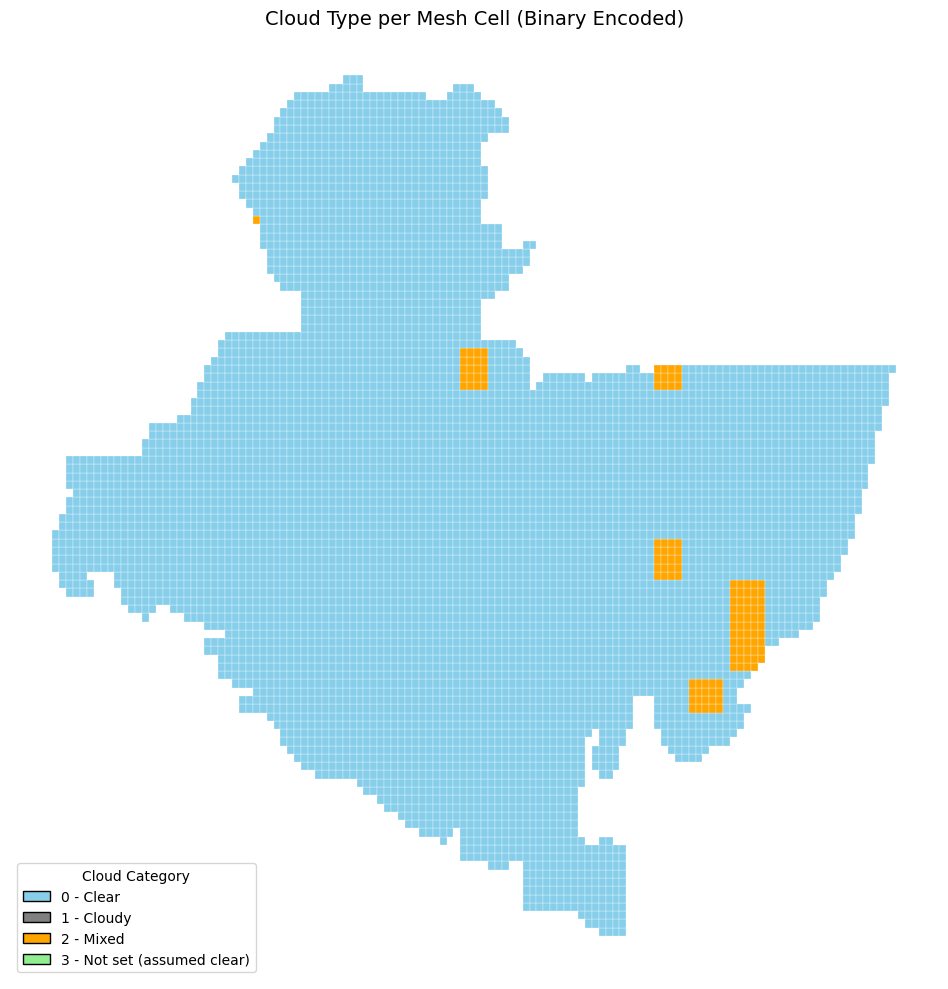

In [6]:
mesh_grid = gpd.read_file(
    DATA_PATH / "baghdad-mesh-data/baghdad-2023-01-01.gpkg", 
    layer=lyr_baghdad_name  # Use the correct layer name
)

plot_cloud_category(mesh_grid)